In [1]:
# # Restart kernel, then run this FIRST:
# import importlib
# import validation.sensitivity_level1 as sens_module
# importlib.reload(sens_module)

# from validation.sensitivity_level1 import morris_sensitivity_level5, SUGGESTED_RANGES_LEVEL5

In [2]:
# import inspect
# from validation.sensitivity_level1 import morris_sensitivity_level5

# # Print the actual source code being used
# source = inspect.getsource(morris_sensitivity_level5)
# print("seed" in source and "seed=seed" in source)  # Should be True

In [3]:
# # =============================================================================
# # REPRODUCIBILITY SETUP - RUN THIS FIRST AFTER KERNEL RESTART
# # =============================================================================
# import numpy as np
# import random

# # Set all random seeds
# SEED = 42
# np.random.seed(SEED)
# random.seed(SEED)

# # Force reload of modules to pick up any changes
# import importlib
# import validation.sensitivity_level1 as sens_module
# importlib.reload(sens_module)

# print("✓ Random seeds set and modules reloaded")

In [4]:
# # =============================================================================
# # REPRODUCIBILITY TEST - Run this cell TWICE and compare results
# # =============================================================================
# import numpy as np
# np.random.seed(42)

# from validation.sensitivity_level1 import morris_sensitivity_level5, SUGGESTED_RANGES_LEVEL5

# Si, problem, Y = morris_sensitivity_level5(
#     SUGGESTED_RANGES_LEVEL5,
#     N_trajectories=10,  # Small for quick test
#     num_levels=4,
#     seed=42,
#     output_metric='flux'
# )

# # Print a fingerprint of the results
# print(f"\n=== REPRODUCIBILITY CHECK ===")
# print(f"Y checksum: {np.sum(Y):.10e}")
# print(f"μ* checksum: {np.sum(Si['mu_star']):.10e}")
# print(f"First 3 μ* values: {Si['mu_star'][:3]}")
# print(f"Top parameter: {problem['names'][np.argmax(Si['mu_star'])]}")

## Level 5 Sensitivity Analysis: Full System (30 Parameters)

Morris screening to identify the most important parameters across all levels:
- **Level 1**: Metal diffusivity & solubility (Arrhenius)
- **Level 2**: Oxide barrier properties
- **Level 3**: Oxide defect paths
- **Level 4**: Metal microstructure (GB + trapping)

In [5]:
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer
from SALib.plotting import morris as morris_plotter
from SALib.sample import saltelli as sobol_sampler
from SALib.analyze import sobol as sobol_analyzer
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# =============================================================================
# LEVEL 5 SENSITIVITY ANALYSIS SETUP
# =============================================================================
from validation.sensitivity_level1 import (
    morris_sensitivity_level5,
    sobol_sensitivity_level5,
    plot_morris_results,
    plot_sobol_results,
    SUGGESTED_RANGES_LEVEL5,
    DEFAULT_PARAMS_LEVEL5,
    VALID_OUTPUT_METRICS_L5
)

# Check what we have
print(f"Number of parameters in SUGGESTED_RANGES_LEVEL5: {len(SUGGESTED_RANGES_LEVEL5)}")
print(f"\nParameters:")
for i, (param, bounds) in enumerate(SUGGESTED_RANGES_LEVEL5.items(), 1):
    print(f"  {i:2d}. {param:<25s}: [{bounds[0]:.2e}, {bounds[1]:.2e}]")

print(f"\nValid output metrics: {VALID_OUTPUT_METRICS_L5}")

Number of parameters in SUGGESTED_RANGES_LEVEL5: 27

Parameters:
   1. D_0                      : [1.00e-08, 1.00e-05]
   2. E_D                      : [4.00e+04, 7.00e+04]
   3. K_s0                     : [1.00e-10, 1.00e-07]
   4. H_s                      : [-4.00e+04, 0.00e+00]
   5. metal_thickness          : [5.00e-04, 5.00e-03]
   6. P_upstream               : [1.00e+03, 1.00e+06]
   7. D_ox_0                   : [1.00e-08, 1.00e-04]
   8. E_D_ox                   : [1.20e+05, 2.00e+05]
   9. K_ox_0                   : [1.00e-06, 1.00e-02]
  10. H_sol_ox                 : [1.50e+05, 2.20e+05]
  11. oxide_thickness          : [1.00e-08, 1.00e-05]
  12. defect_fraction          : [1.00e-04, 1.00e-01]
  13. crack_thickness_factor   : [1.00e-02, 5.00e-01]
  14. gb_diffusivity_factor    : [1.00e+00, 1.00e+02]
  15. grain_size               : [1.00e-07, 1.00e-04]
  16. gb_thickness             : [3.00e-10, 1.00e-09]
  17. gb_enhancement_factor    : [1.00e+01, 1.00e+03]
  18. lattice_de

In [11]:
# =============================================================================
# SETUP - RUN ONCE AFTER KERNEL RESTART
# =============================================================================
import numpy as np
import random
import importlib

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Force reload of modules
import validation.sensitivity_level1 as sens_module
importlib.reload(sens_module)

# Import everything needed
from validation.sensitivity_level1 import (
    morris_sensitivity_level5,
    sobol_sensitivity_level5,
    plot_morris_results,
    plot_sobol_results,
    SUGGESTED_RANGES_LEVEL5,
    DEFAULT_PARAMS_LEVEL5,
    VALID_OUTPUT_METRICS_L5
)

print("✓ Setup complete")
print(f"  Parameters: {len(SUGGESTED_RANGES_LEVEL5)}")
print(f"  Output metrics: {VALID_OUTPUT_METRICS_L5}")

✓ Setup complete
  Parameters: 27
  Output metrics: ['flux', 'PRF', 'D_eff', 'D_modification', 'permeability', 'P_interface', 'flux_intact', 'flux_defect']


##### Convergence test

In [25]:
# #Step 1: Get the parameter names once:  Run once to extract problem definition
# Si_ref, problem, _ = morris_sensitivity_level5(
#     SUGGESTED_RANGES_LEVEL5,
#     N_trajectories=50,      # small, just to get problem
#     num_levels=16,
#     seed=42,
#     output_metric='flux'
# )

# param_names = problem['names']


In [ ]:
# #initialize storage correctly
# trajectory_counts = [
#     50, 100, 200, 300, 400, 500, 600, 700,
#     800, 900, 1000, 1100, 1200, 1300, 1400,
#     1500, 1600, 1700, 1800, 1900, 2000
# ]

# mu_star_history = {p: [] for p in param_names}


In [26]:
# # Step 3: Run Morris Progressively
# for N in trajectory_counts:
#     print(f"Running Morris with N = {N}")
    
#     Si, _, _ = morris_sensitivity_level5(
#         SUGGESTED_RANGES_LEVEL5,
#         N_trajectories=N,
#         num_levels=16,
#         #seed=42,                 # CRITICAL: fixed seed
#         output_metric='flux'
#     )
    
#     for i, p in enumerate(param_names):
#         mu_star_history[p].append(Si['mu_star'][i])


In [27]:
# # Step 4: Plot only importan parameters
# import matplotlib.pyplot as plt

# key_params = [
#     'H_s',
#     'E_D',
#     'temperature',
#     'K_s0',
#     'metal_thickness'
# ]

# for p in key_params:
#     plt.figure()
#     plt.plot(trajectory_counts, mu_star_history[p], marker='o')
#     plt.xlabel("Number of Morris trajectories")
#     plt.ylabel("μ*")
#     plt.title(f"Morris convergence: {p}")
#     plt.grid(True)
#     plt.show()


In [16]:
# =============================================================================
# MORRIS ANALYSIS: ALL VALID OUTPUT METRICS
# =============================================================================
# Run Morris screening for each output metric and store results

morris_results = {}

for output_metric in VALID_OUTPUT_METRICS_L5:
    print(f"\n{'#'*70}")
    print(f"# Running Morris for: {output_metric}")
    print(f"{'#'*70}")
    
    Si, problem, Y = morris_sensitivity_level5(
        SUGGESTED_RANGES_LEVEL5,
        N_trajectories=500,
        num_levels=4,
        seed=42,
        output_metric=output_metric
        
    )
    
    morris_results[output_metric] = {
        'Si': Si,
        'problem': problem,
        'Y': Y
    }
    
print("\n" + "="*70)
print("✓ Morris analysis complete for all output metrics!")
print("="*70)


######################################################################
# Running Morris for: flux
######################################################################

MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 14000 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstream, D_ox_0, E_D_ox, K_ox_0, H_sol_ox, oxide_thickness, defect_fraction, crack_thickness_factor, gb_diffusivity_factor, grain_size, gb_thickness, gb_enhancement_factor, lattice_density, sites_per_area, trap_dislocation_E_b, trap_dislocation_N_T, trap_gb_E_b, trap_vacancy_E_b, trap_vacancy_N_T, trap_carbide_E_b, trap_carbide_N_T, temperature
Output metric: flux

  Completed 10/14000 samples
  Completed 20/14000 samples
  Completed 30/14000 samples
  Completed 40/14000 samples
  Completed 50/14000 samples
  Completed 60/14000 samples
  Completed 70/14000 samples
  Completed 80/14000 samples
  Completed 90/14000 samples
  Completed 100/14000 samples
  Completed 

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 7.14e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.14e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.74e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 480/14000 samples
  Completed 490/14000 samples
  Completed 500/14000 samples
  Completed 510/14000 samples
  Completed 520/14000 samples
  Completed 530/14000 samples
  Completed 540/14000 samples
  Completed 550/14000 samples
  Completed 560/14000 samples
  Completed 570/14000 samples
  Completed 580/14000 samples
  Completed 590/14000 samples
  Completed 600/14000 samples
  Completed 610/14000 samples
  Completed 620/14000 samples
  Completed 630/14000 samples
  Completed 640/14000 samples
  Completed 650/14000 samples
  Completed 660/14000 samples
  Completed 670/14000 samples
  Completed 680/14000 samples
  Completed 690/14000 samples
  Completed 700/14000 samples
  Completed 710/14000 samples
  Completed 720/14000 samples
  Completed 730/14000 samples
  Completed 740/14000 samples
  Completed 750/14000 samples
  Completed 760/14000 samples
  Completed 770/14000 samples
  Completed 780/14000 samples
  Completed 790/14000 samples
  Completed 800/14000 samples
  Complete

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 9.13e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 8.15e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 890/14000 samples
  Completed 900/14000 samples
  Completed 910/14000 samples
  Completed 920/14000 samples
  Completed 930/14000 samples
  Completed 940/14000 samples
  Completed 950/14000 samples
  Completed 960/14000 samples
  Completed 970/14000 samples
  Completed 980/14000 samples
  Completed 990/14000 samples
  Completed 1000/14000 samples
  Completed 1010/14000 samples
  Completed 1020/14000 samples
  Completed 1030/14000 samples
  Completed 1040/14000 samples
  Completed 1050/14000 samples
  Completed 1060/14000 samples
  Completed 1070/14000 samples
  Completed 1080/14000 samples
  Completed 1090/14000 samples
  Completed 1100/14000 samples
  Completed 1110/14000 samples
  Completed 1120/14000 samples
  Completed 1130/14000 samples
  Completed 1140/14000 samples
  Completed 1150/14000 samples
  Completed 1160/14000 samples
  Completed 1170/14000 samples
  Completed 1180/14000 samples
  Completed 1190/14000 samples
  Completed 1200/14000 samples
  Completed 1210/14

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.75e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 8.14e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.43e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction 

  Completed 2020/14000 samples
  Completed 2030/14000 samples
  Completed 2040/14000 samples
  Completed 2050/14000 samples
  Completed 2060/14000 samples
  Completed 2070/14000 samples
  Completed 2080/14000 samples
  Completed 2090/14000 samples
  Completed 2100/14000 samples
  Completed 2110/14000 samples
  Completed 2120/14000 samples
  Completed 2130/14000 samples
  Completed 2140/14000 samples
  Completed 2150/14000 samples
  Completed 2160/14000 samples
  Completed 2170/14000 samples
  Completed 2180/14000 samples
  Completed 2190/14000 samples
  Completed 2200/14000 samples
  Completed 2210/14000 samples
  Completed 2220/14000 samples
  Completed 2230/14000 samples
  Completed 2240/14000 samples
  Completed 2250/14000 samples
  Completed 2260/14000 samples
  Completed 2270/14000 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 6.10e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 2280/14000 samples
  Completed 2290/14000 samples
  Completed 2300/14000 samples
  Completed 2310/14000 samples
  Completed 2320/14000 samples
  Completed 2330/14000 samples
  Completed 2340/14000 samples
  Completed 2350/14000 samples
  Completed 2360/14000 samples
  Completed 2370/14000 samples
  Completed 2380/14000 samples
  Completed 2390/14000 samples
  Completed 2400/14000 samples
  Completed 2410/14000 samples
  Completed 2420/14000 samples
  Completed 2430/14000 samples
  Completed 2440/14000 samples
  Completed 2450/14000 samples
  Completed 2460/14000 samples
  Completed 2470/14000 samples
  Completed 2480/14000 samples
  Completed 2490/14000 samples
  Completed 2500/14000 samples
  Completed 2510/14000 samples
  Completed 2520/14000 samples
  Completed 2530/14000 samples
  Completed 2540/14000 samples
  Completed 2550/14000 samples
  Completed 2560/14000 samples
  Completed 2570/14000 samples
  Completed 2580/14000 samples
  Completed 2590/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.07e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.63e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 7.08e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction 

  Completed 2970/14000 samples
  Completed 2980/14000 samples
  Completed 2990/14000 samples
  Completed 3000/14000 samples
  Completed 3010/14000 samples
  Completed 3020/14000 samples
  Completed 3030/14000 samples
  Completed 3040/14000 samples
  Completed 3050/14000 samples
  Completed 3060/14000 samples
  Completed 3070/14000 samples
  Completed 3080/14000 samples
  Completed 3090/14000 samples
  Completed 3100/14000 samples
  Completed 3110/14000 samples
  Completed 3120/14000 samples
  Completed 3130/14000 samples
  Completed 3140/14000 samples
  Completed 3150/14000 samples
  Completed 3160/14000 samples
  Completed 3170/14000 samples
  Completed 3180/14000 samples
  Completed 3190/14000 samples
  Completed 3200/14000 samples
  Completed 3210/14000 samples
  Completed 3220/14000 samples
  Completed 3230/14000 samples
  Completed 3240/14000 samples
  Completed 3250/14000 samples
  Completed 3260/14000 samples
  Completed 3270/14000 samples
  Completed 3280/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.44e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 3300/14000 samples
  Completed 3310/14000 samples
  Completed 3320/14000 samples
  Completed 3330/14000 samples
  Completed 3340/14000 samples
  Completed 3350/14000 samples
  Completed 3360/14000 samples
  Completed 3370/14000 samples
  Completed 3380/14000 samples
  Completed 3390/14000 samples
  Completed 3400/14000 samples
  Completed 3410/14000 samples
  Completed 3420/14000 samples
  Completed 3430/14000 samples
  Completed 3440/14000 samples
  Completed 3450/14000 samples
  Completed 3460/14000 samples
  Completed 3470/14000 samples
  Completed 3480/14000 samples
  Completed 3490/14000 samples
  Completed 3500/14000 samples
  Completed 3510/14000 samples
  Completed 3520/14000 samples
  Completed 3530/14000 samples
  Completed 3540/14000 samples
  Completed 3550/14000 samples
  Completed 3560/14000 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.21e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 7.03e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.20e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 3570/14000 samples
  Completed 3580/14000 samples
  Completed 3590/14000 samples
  Completed 3600/14000 samples
  Completed 3610/14000 samples
  Completed 3620/14000 samples
  Completed 3630/14000 samples
  Completed 3640/14000 samples
  Completed 3650/14000 samples
  Completed 3660/14000 samples
  Completed 3670/14000 samples
  Completed 3680/14000 samples
  Completed 3690/14000 samples
  Completed 3700/14000 samples
  Completed 3710/14000 samples
  Completed 3720/14000 samples
  Completed 3730/14000 samples
  Completed 3740/14000 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.00e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 6.98e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.72e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction 

  Completed 3750/14000 samples
  Completed 3760/14000 samples
  Completed 3770/14000 samples
  Completed 3780/14000 samples
  Completed 3790/14000 samples
  Completed 3800/14000 samples
  Completed 3810/14000 samples
  Completed 3820/14000 samples
  Completed 3830/14000 samples
  Completed 3840/14000 samples
  Completed 3850/14000 samples
  Completed 3860/14000 samples
  Completed 3870/14000 samples
  Completed 3880/14000 samples
  Completed 3890/14000 samples
  Completed 3900/14000 samples
  Completed 3910/14000 samples
  Completed 3920/14000 samples
  Completed 3930/14000 samples
  Completed 3940/14000 samples
  Completed 3950/14000 samples
  Completed 3960/14000 samples
  Completed 3970/14000 samples
  Completed 3980/14000 samples
  Completed 3990/14000 samples
  Completed 4000/14000 samples
  Completed 4010/14000 samples
  Completed 4020/14000 samples
  Completed 4030/14000 samples
  Completed 4040/14000 samples
  Completed 4050/14000 samples
  Completed 4060/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.37e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 4090/14000 samples
  Completed 4100/14000 samples
  Completed 4110/14000 samples
  Completed 4120/14000 samples
  Completed 4130/14000 samples
  Completed 4140/14000 samples
  Completed 4150/14000 samples
  Completed 4160/14000 samples
  Completed 4170/14000 samples
  Completed 4180/14000 samples
  Completed 4190/14000 samples
  Completed 4200/14000 samples
  Completed 4210/14000 samples
  Completed 4220/14000 samples
  Completed 4230/14000 samples
  Completed 4240/14000 samples
  Completed 4250/14000 samples
  Completed 4260/14000 samples
  Completed 4270/14000 samples
  Completed 4280/14000 samples
  Completed 4290/14000 samples
  Completed 4300/14000 samples
  Completed 4310/14000 samples
  Completed 4320/14000 samples
  Completed 4330/14000 samples
  Completed 4340/14000 samples
  Completed 4350/14000 samples
  Completed 4360/14000 samples
  Completed 4370/14000 samples
  Completed 4380/14000 samples
  Completed 4390/14000 samples
  Completed 4400/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (5.49×) and trapping (0.21×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.42e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.03e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 4440/14000 samples
  Completed 4450/14000 samples
  Completed 4460/14000 samples
  Completed 4470/14000 samples
  Completed 4480/14000 samples
  Completed 4490/14000 samples
  Completed 4500/14000 samples
  Completed 4510/14000 samples
  Completed 4520/14000 samples
  Completed 4530/14000 samples
  Completed 4540/14000 samples
  Completed 4550/14000 samples
  Completed 4560/14000 samples
  Completed 4570/14000 samples
  Completed 4580/14000 samples
  Completed 4590/14000 samples
  Completed 4600/14000 samples
  Completed 4610/14000 samples
  Completed 4620/14000 samples
  Completed 4630/14000 samples
  Completed 4640/14000 samples
  Completed 4650/14000 samples
  Completed 4660/14000 samples
  Completed 4670/14000 samples
  Completed 4680/14000 samples
  Completed 4690/14000 samples
  Completed 4700/14000 samples
  Completed 4710/14000 samples
  Completed 4720/14000 samples
  Completed 4730/14000 samples
  Completed 4740/14000 samples
  Completed 4750/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.69e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 5360/14000 samples
  Completed 5370/14000 samples
  Completed 5380/14000 samples
  Completed 5390/14000 samples
  Completed 5400/14000 samples
  Completed 5410/14000 samples
  Completed 5420/14000 samples
  Completed 5430/14000 samples
  Completed 5440/14000 samples
  Completed 5450/14000 samples
  Completed 5460/14000 samples
  Completed 5470/14000 samples
  Completed 5480/14000 samples
  Completed 5490/14000 samples
  Completed 5500/14000 samples
  Completed 5510/14000 samples
  Completed 5520/14000 samples
  Completed 5530/14000 samples
  Completed 5540/14000 samples
  Completed 5550/14000 samples
  Completed 5560/14000 samples
  Completed 5570/14000 samples
  Completed 5580/14000 samples
  Completed 5590/14000 samples
  Completed 5600/14000 samples
  Completed 5610/14000 samples
  Completed 5620/14000 samples
  Completed 5630/14000 samples
  Completed 5640/14000 samples
  Completed 5650/14000 samples
  Completed 5660/14000 samples
  Completed 5670/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (15.97×) and trapping (0.06×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.29e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (12.48×) and trapping (0.08×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 5890/14000 samples
  Completed 5900/14000 samples
  Completed 5910/14000 samples
  Completed 5920/14000 samples
  Completed 5930/14000 samples
  Completed 5940/14000 samples
  Completed 5950/14000 samples
  Completed 5960/14000 samples
  Completed 5970/14000 samples
  Completed 5980/14000 samples
  Completed 5990/14000 samples
  Completed 6000/14000 samples
  Completed 6010/14000 samples
  Completed 6020/14000 samples
  Completed 6030/14000 samples
  Completed 6040/14000 samples
  Completed 6050/14000 samples
  Completed 6060/14000 samples
  Completed 6070/14000 samples
  Completed 6080/14000 samples
  Completed 6090/14000 samples
  Completed 6100/14000 samples
  Completed 6110/14000 samples
  Completed 6120/14000 samples
  Completed 6130/14000 samples
  Completed 6140/14000 samples
  Completed 6150/14000 samples
  Completed 6160/14000 samples
  Completed 6170/14000 samples
  Completed 6180/14000 samples
  Completed 6190/14000 samples
  Completed 6200/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 6.12e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.06e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 6470/14000 samples
  Completed 6480/14000 samples
  Completed 6490/14000 samples
  Completed 6500/14000 samples
  Completed 6510/14000 samples
  Completed 6520/14000 samples
  Completed 6530/14000 samples
  Completed 6540/14000 samples
  Completed 6550/14000 samples
  Completed 6560/14000 samples
  Completed 6570/14000 samples
  Completed 6580/14000 samples
  Completed 6590/14000 samples
  Completed 6600/14000 samples
  Completed 6610/14000 samples
  Completed 6620/14000 samples
  Completed 6630/14000 samples
  Completed 6640/14000 samples
  Completed 6650/14000 samples
  Completed 6660/14000 samples
  Completed 6670/14000 samples
  Completed 6680/14000 samples
  Completed 6690/14000 samples
  Completed 6700/14000 samples
  Completed 6710/14000 samples
  Completed 6720/14000 samples
  Completed 6730/14000 samples
  Completed 6740/14000 samples
  Completed 6750/14000 samples
  Completed 6760/14000 samples
  Completed 6770/14000 samples
  Completed 6780/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.39e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 8.09e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 7360/14000 samples
  Completed 7370/14000 samples
  Completed 7380/14000 samples
  Completed 7390/14000 samples
  Completed 7400/14000 samples
  Completed 7410/14000 samples
  Completed 7420/14000 samples
  Completed 7430/14000 samples
  Completed 7440/14000 samples
  Completed 7450/14000 samples
  Completed 7460/14000 samples
  Completed 7470/14000 samples
  Completed 7480/14000 samples
  Completed 7490/14000 samples
  Completed 7500/14000 samples
  Completed 7510/14000 samples
  Completed 7520/14000 samples
  Completed 7530/14000 samples
  Completed 7540/14000 samples
  Completed 7550/14000 samples
  Completed 7560/14000 samples
  Completed 7570/14000 samples
  Completed 7580/14000 samples
  Completed 7590/14000 samples
  Completed 7600/14000 samples
  Completed 7610/14000 samples
  Completed 7620/14000 samples
  Completed 7630/14000 samples
  Completed 7640/14000 samples
  Completed 7650/14000 samples
  Completed 7660/14000 samples
  Completed 7670/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 6.11e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 7800/14000 samples
  Completed 7810/14000 samples
  Completed 7820/14000 samples
  Completed 7830/14000 samples
  Completed 7840/14000 samples
  Completed 7850/14000 samples
  Completed 7860/14000 samples
  Completed 7870/14000 samples
  Completed 7880/14000 samples
  Completed 7890/14000 samples
  Completed 7900/14000 samples
  Completed 7910/14000 samples
  Completed 7920/14000 samples
  Completed 7930/14000 samples
  Completed 7940/14000 samples
  Completed 7950/14000 samples
  Completed 7960/14000 samples
  Completed 7970/14000 samples
  Completed 7980/14000 samples
  Completed 7990/14000 samples
  Completed 8000/14000 samples
  Completed 8010/14000 samples
  Completed 8020/14000 samples
  Completed 8030/14000 samples
  Completed 8040/14000 samples
  Completed 8050/14000 samples
  Completed 8060/14000 samples
  Completed 8070/14000 samples
  Completed 8080/14000 samples
  Completed 8090/14000 samples
  Completed 8100/14000 samples
  Completed 8110/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (12.48×) and trapping (0.07×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 8730/14000 samples
  Completed 8740/14000 samples
  Completed 8750/14000 samples
  Completed 8760/14000 samples
  Completed 8770/14000 samples
  Completed 8780/14000 samples
  Completed 8790/14000 samples
  Completed 8800/14000 samples
  Completed 8810/14000 samples
  Completed 8820/14000 samples
  Completed 8830/14000 samples
  Completed 8840/14000 samples
  Completed 8850/14000 samples
  Completed 8860/14000 samples
  Completed 8870/14000 samples
  Completed 8880/14000 samples
  Completed 8890/14000 samples
  Completed 8900/14000 samples
  Completed 8910/14000 samples
  Completed 8920/14000 samples
  Completed 8930/14000 samples
  Completed 8940/14000 samples
  Completed 8950/14000 samples
  Completed 8960/14000 samples
  Completed 8970/14000 samples
  Completed 8980/14000 samples
  Completed 8990/14000 samples
  Completed 9000/14000 samples
  Completed 9010/14000 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (8.98×) and trapping (0.09×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 9020/14000 samples
  Completed 9030/14000 samples
  Completed 9040/14000 samples
  Completed 9050/14000 samples
  Completed 9060/14000 samples
  Completed 9070/14000 samples
  Completed 9080/14000 samples
  Completed 9090/14000 samples
  Completed 9100/14000 samples
  Completed 9110/14000 samples
  Completed 9120/14000 samples
  Completed 9130/14000 samples
  Completed 9140/14000 samples
  Completed 9150/14000 samples
  Completed 9160/14000 samples
  Completed 9170/14000 samples
  Completed 9180/14000 samples
  Completed 9190/14000 samples
  Completed 9200/14000 samples
  Completed 9210/14000 samples
  Completed 9220/14000 samples
  Completed 9230/14000 samples
  Completed 9240/14000 samples
  Completed 9250/14000 samples
  Completed 9260/14000 samples
  Completed 9270/14000 samples
  Completed 9280/14000 samples
  Completed 9290/14000 samples
  Completed 9300/14000 samples
  Completed 9310/14000 samples
  Completed 9320/14000 samples
  Completed 9330/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 8.13e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 9360/14000 samples
  Completed 9370/14000 samples
  Completed 9380/14000 samples
  Completed 9390/14000 samples
  Completed 9400/14000 samples
  Completed 9410/14000 samples
  Completed 9420/14000 samples
  Completed 9430/14000 samples
  Completed 9440/14000 samples
  Completed 9450/14000 samples
  Completed 9460/14000 samples
  Completed 9470/14000 samples
  Completed 9480/14000 samples
  Completed 9490/14000 samples
  Completed 9500/14000 samples
  Completed 9510/14000 samples
  Completed 9520/14000 samples
  Completed 9530/14000 samples
  Completed 9540/14000 samples
  Completed 9550/14000 samples
  Completed 9560/14000 samples
  Completed 9570/14000 samples
  Completed 9580/14000 samples
  Completed 9590/14000 samples
  Completed 9600/14000 samples
  Completed 9610/14000 samples
  Completed 9620/14000 samples
  Completed 9630/14000 samples
  Completed 9640/14000 samples
  Completed 9650/14000 samples
  Completed 9660/14000 samples
  Completed 9670/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 7.12e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 9840/14000 samples
  Completed 9850/14000 samples
  Completed 9860/14000 samples
  Completed 9870/14000 samples
  Completed 9880/14000 samples
  Completed 9890/14000 samples
  Completed 9900/14000 samples
  Completed 9910/14000 samples
  Completed 9920/14000 samples
  Completed 9930/14000 samples
  Completed 9940/14000 samples
  Completed 9950/14000 samples
  Completed 9960/14000 samples
  Completed 9970/14000 samples
  Completed 9980/14000 samples
  Completed 9990/14000 samples
  Completed 10000/14000 samples
  Completed 10010/14000 samples
  Completed 10020/14000 samples
  Completed 10030/14000 samples
  Completed 10040/14000 samples
  Completed 10050/14000 samples
  Completed 10060/14000 samples
  Completed 10070/14000 samples
  Completed 10080/14000 samples
  Completed 10090/14000 samples
  Completed 10100/14000 samples
  Completed 10110/14000 samples
  Completed 10120/14000 samples
  Completed 10130/14000 samples
  Completed 10140/14000 samples
  Completed 10150/14000 

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 9.04e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 10700/14000 samples
  Completed 10710/14000 samples
  Completed 10720/14000 samples
  Completed 10730/14000 samples
  Completed 10740/14000 samples
  Completed 10750/14000 samples
  Completed 10760/14000 samples
  Completed 10770/14000 samples
  Completed 10780/14000 samples
  Completed 10790/14000 samples
  Completed 10800/14000 samples
  Completed 10810/14000 samples
  Completed 10820/14000 samples
  Completed 10830/14000 samples
  Completed 10840/14000 samples
  Completed 10850/14000 samples
  Completed 10860/14000 samples
  Completed 10870/14000 samples
  Completed 10880/14000 samples
  Completed 10890/14000 samples
  Completed 10900/14000 samples
  Completed 10910/14000 samples
  Completed 10920/14000 samples
  Completed 10930/14000 samples
  Completed 10940/14000 samples
  Completed 10950/14000 samples
  Completed 10960/14000 samples
  Completed 10970/14000 samples
  Completed 10980/14000 samples
  Completed 10990/14000 samples
  Completed 11000/14000 samples
  Comple

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 8.87e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 13770/14000 samples
  Completed 13780/14000 samples
  Completed 13790/14000 samples
  Completed 13800/14000 samples
  Completed 13810/14000 samples
  Completed 13820/14000 samples
  Completed 13830/14000 samples
  Completed 13840/14000 samples
  Completed 13850/14000 samples
  Completed 13860/14000 samples
  Completed 13870/14000 samples
  Completed 13880/14000 samples
  Completed 13890/14000 samples
  Completed 13900/14000 samples
  Completed 13910/14000 samples
  Completed 13920/14000 samples
  Completed 13930/14000 samples
  Completed 13940/14000 samples
  Completed 13950/14000 samples
  Completed 13960/14000 samples
  Completed 13970/14000 samples
  Completed 13980/14000 samples
  Completed 13990/14000 samples
  Completed 14000/14000 samples

✓ Morris analysis complete
  Output range: [2.21e-24, 7.47e-07]
  Output span: 338902208760608640.0× variation

  Top 10 most influential parameters:
    1. P_upstream: μ* = 3.68e-09
    2. temperature: μ* = 3.48e-09
    3. defect_

In [17]:
morris_results

{'flux': {'Si': {'names': array(['D_0', 'E_D', 'K_s0', 'H_s', 'metal_thickness', 'P_upstream',
          'D_ox_0', 'E_D_ox', 'K_ox_0', 'H_sol_ox', 'oxide_thickness',
          'defect_fraction', 'crack_thickness_factor',
          'gb_diffusivity_factor', 'grain_size', 'gb_thickness',
          'gb_enhancement_factor', 'lattice_density', 'sites_per_area',
          'trap_dislocation_E_b', 'trap_dislocation_N_T', 'trap_gb_E_b',
          'trap_vacancy_E_b', 'trap_vacancy_N_T', 'trap_carbide_E_b',
          'trap_carbide_N_T', 'temperature'], dtype='<U22'),
   'mu': masked_array(data=[1.7337719875387413e-09, -2.7488394831309265e-09,
                      2.985212437096747e-09, -2.659619709027396e-09,
                      -1.3117026671129904e-09, 3.6817233588653105e-09,
                      5.102171745657516e-10, -8.310744823949063e-10,
                      3.248273810138794e-10, -1.1221306821097652e-09,
                      -6.534259710963409e-10, 3.0233435799369335e-09, 0.0,
       


OUTPUT: flux


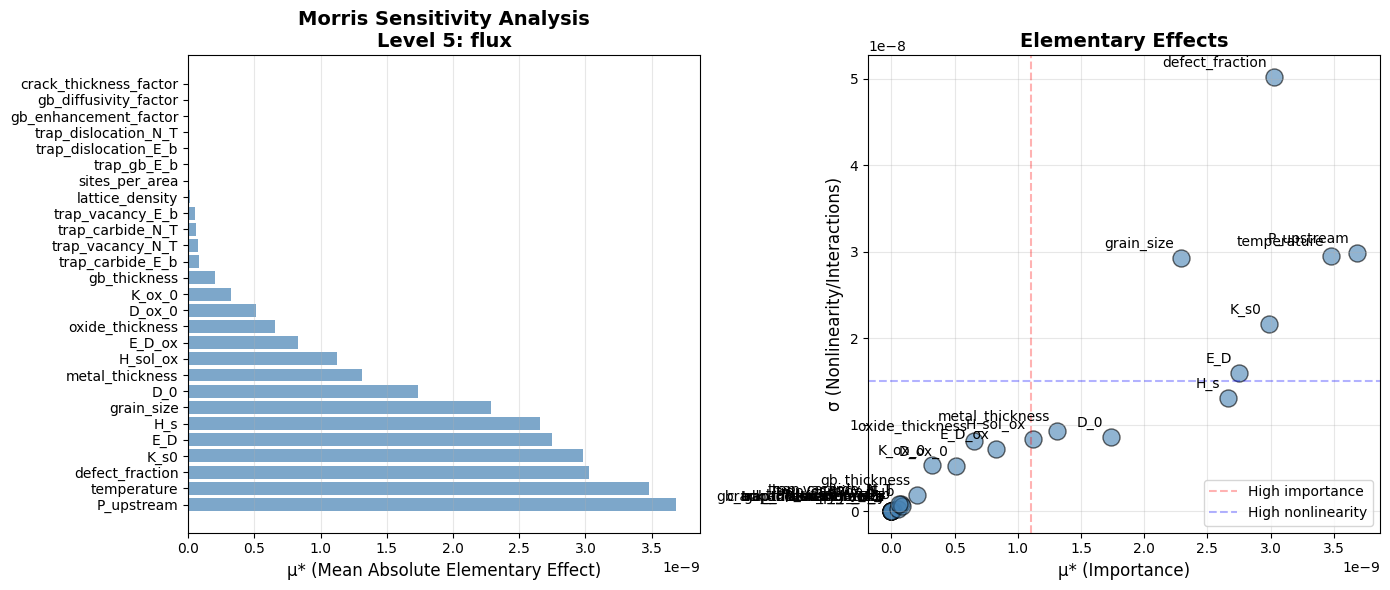


MORRIS SENSITIVITY RESULTS - Level 5: flux
             Parameter           μ*            σ      μ*_conf
            P_upstream 3.681723e-09 2.981717e-08 2.544148e-09
           temperature 3.477770e-09 2.956206e-08 2.657679e-09
       defect_fraction 3.023344e-09 5.022705e-08 4.252662e-09
                  K_s0 2.985212e-09 2.165113e-08 1.883072e-09
                   E_D 2.748839e-09 1.593194e-08 1.302571e-09
                   H_s 2.659620e-09 1.310029e-08 1.297513e-09
            grain_size 2.288549e-09 2.930932e-08 2.931822e-09
                   D_0 1.733772e-09 8.570289e-09 6.919957e-10
       metal_thickness 1.311703e-09 9.288650e-09 7.199477e-10
              H_sol_ox 1.122131e-09 8.341076e-09 7.240831e-10
                E_D_ox 8.310745e-10 7.174493e-09 5.731253e-10
       oxide_thickness 6.534260e-10 8.077439e-09 7.244385e-10
                D_ox_0 5.102172e-10 5.240862e-09 4.787313e-10
                K_ox_0 3.248274e-10 5.302491e-09 4.508385e-10
          gb_thickness 2.0

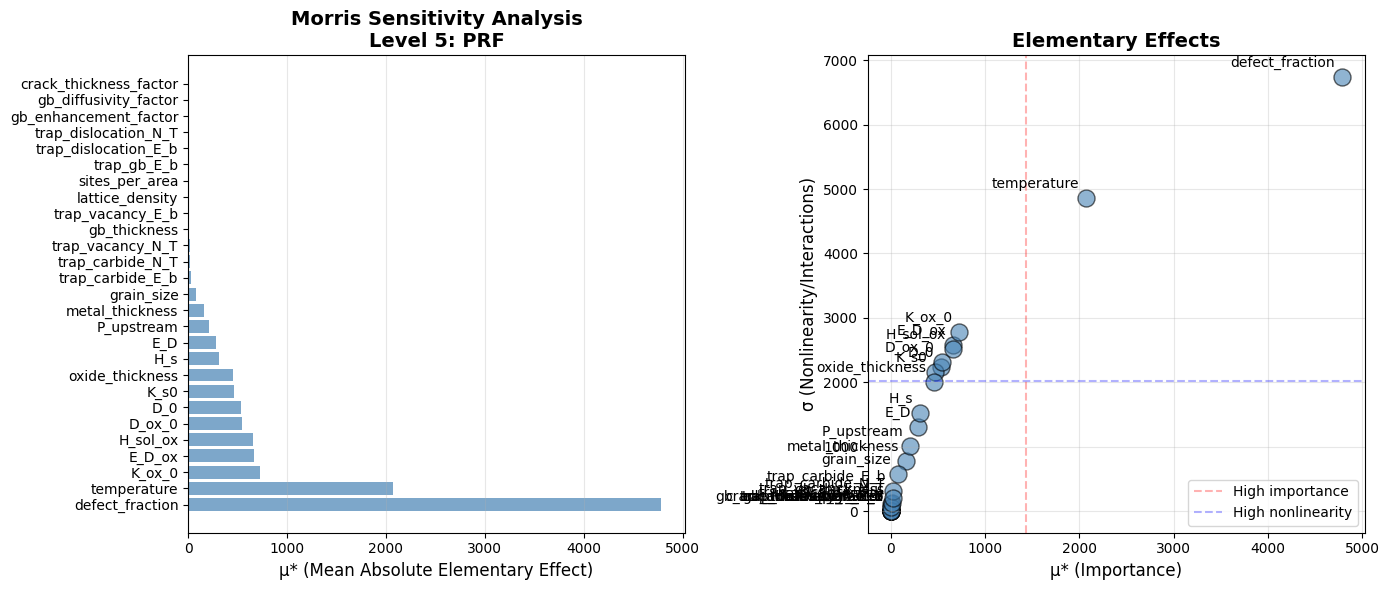


MORRIS SENSITIVITY RESULTS - Level 5: PRF
             Parameter           μ*            σ      μ*_conf
       defect_fraction 4.782331e+03 6.740029e+03 6.166865e+02
           temperature 2.073212e+03 4.854714e+03 4.519881e+02
                K_ox_0 7.274997e+02 2.787212e+03 2.523271e+02
                E_D_ox 6.608007e+02 2.574594e+03 2.107924e+02
              H_sol_ox 6.576629e+02 2.511110e+03 2.225352e+02
                D_ox_0 5.401209e+02 2.309098e+03 2.033614e+02
                   D_0 5.350887e+02 2.230045e+03 2.060815e+02
                  K_s0 4.668478e+02 2.153846e+03 1.879856e+02
       oxide_thickness 4.557252e+02 2.007655e+03 1.814547e+02
                   H_s 3.113342e+02 1.520351e+03 1.181514e+02
                   E_D 2.860097e+02 1.302049e+03 1.002182e+02
            P_upstream 2.064871e+02 1.012795e+03 8.206356e+01
       metal_thickness 1.625512e+02 7.840410e+02 6.474846e+01
            grain_size 8.043017e+01 5.718231e+02 5.316913e+01
      trap_carbide_E_b 2.91

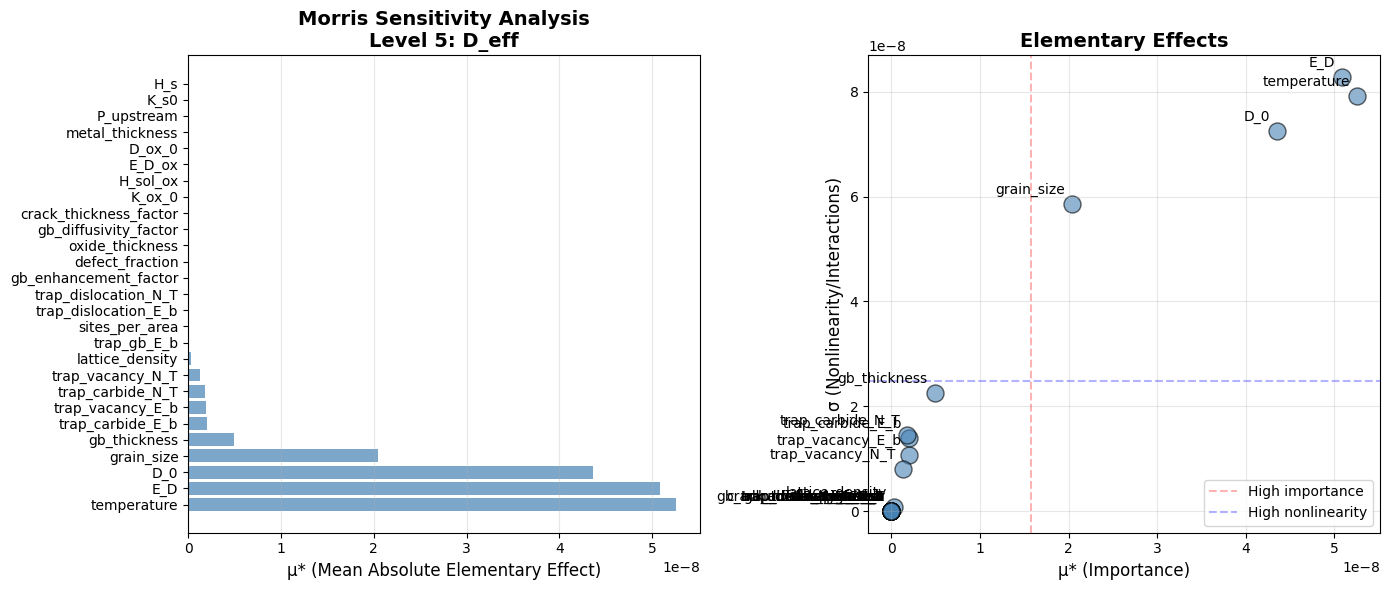


MORRIS SENSITIVITY RESULTS - Level 5: D_eff
             Parameter           μ*            σ      μ*_conf
           temperature 5.253088e-08 7.917393e-08 6.884110e-09
                   E_D 5.084593e-08 8.285128e-08 6.624983e-09
                   D_0 4.357319e-08 7.253134e-08 5.387752e-09
            grain_size 2.040723e-08 5.859021e-08 4.482503e-09
          gb_thickness 4.890294e-09 2.245354e-08 2.000231e-09
      trap_carbide_E_b 2.005141e-09 1.399257e-08 1.203310e-09
      trap_vacancy_E_b 1.932127e-09 1.074285e-08 1.036488e-09
      trap_carbide_N_T 1.759795e-09 1.458197e-08 1.290656e-09
      trap_vacancy_N_T 1.311766e-09 7.971020e-09 6.581071e-10
       lattice_density 2.590202e-10 8.189601e-10 8.362587e-11
           trap_gb_E_b 6.753989e-18 3.155355e-17 2.614118e-18
        sites_per_area 5.190059e-18 2.868374e-17 2.569753e-18
  trap_dislocation_E_b 6.446530e-19 2.965947e-18 2.360111e-19
  trap_dislocation_N_T 4.375856e-19 1.563389e-18 1.337436e-19
 gb_enhancement_factor 0.

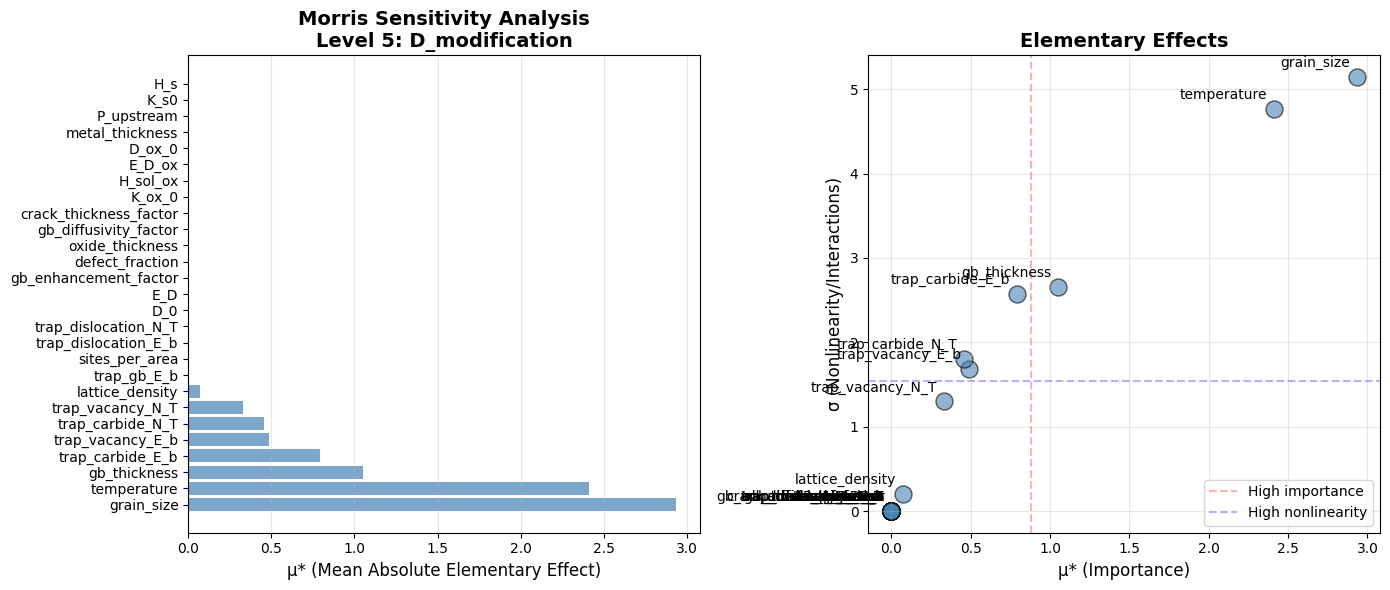


MORRIS SENSITIVITY RESULTS - Level 5: D_modification
             Parameter           μ*            σ      μ*_conf
            grain_size 2.932449e+00 5.144304e+00 4.026644e-01
           temperature 2.411147e+00 4.765213e+00 3.958426e-01
          gb_thickness 1.051602e+00 2.656563e+00 2.329514e-01
      trap_carbide_E_b 7.914260e-01 2.567683e+00 2.380300e-01
      trap_vacancy_E_b 4.878156e-01 1.678382e+00 1.207999e-01
      trap_carbide_N_T 4.577751e-01 1.798297e+00 1.717532e-01
      trap_vacancy_N_T 3.306423e-01 1.298542e+00 1.128941e-01
       lattice_density 7.189324e-02 2.020207e-01 1.765149e-02
           trap_gb_E_b 6.757407e-09 4.970767e-08 4.307110e-09
        sites_per_area 5.375858e-09 6.267863e-08 5.211244e-09
  trap_dislocation_E_b 1.708032e-10 6.904961e-10 5.239925e-11
  trap_dislocation_N_T 1.013803e-10 4.085631e-10 3.607822e-11
                   D_0 4.068107e-16 1.100041e-15 8.901080e-17
                   E_D 3.287374e-16 8.060945e-16 6.455546e-17
 gb_enhancement_

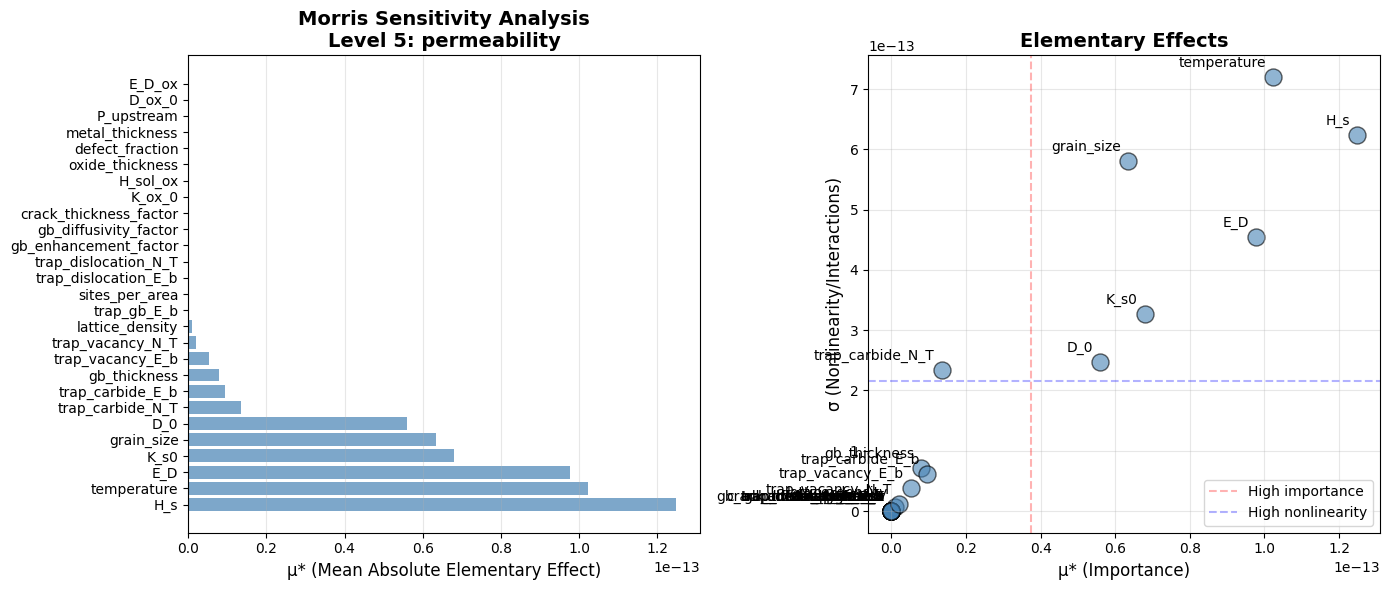


MORRIS SENSITIVITY RESULTS - Level 5: permeability
             Parameter           μ*            σ      μ*_conf
                   H_s 1.247454e-13 6.236267e-13 5.027410e-14
           temperature 1.024223e-13 7.200023e-13 5.308709e-14
                   E_D 9.778384e-14 4.550943e-13 3.678952e-14
                  K_s0 6.791693e-14 3.268379e-13 3.094280e-14
            grain_size 6.341149e-14 5.805872e-13 5.060977e-14
                   D_0 5.592141e-14 2.477575e-13 2.010251e-14
      trap_carbide_N_T 1.350531e-14 2.339783e-13 2.171927e-14
      trap_carbide_E_b 9.474521e-15 6.124652e-14 5.747614e-15
          gb_thickness 7.901054e-15 7.107425e-14 5.426347e-15
      trap_vacancy_E_b 5.198662e-15 3.759333e-14 2.947920e-15
      trap_vacancy_N_T 2.091033e-15 1.130353e-14 1.122835e-15
       lattice_density 1.006160e-15 6.702143e-15 5.767001e-16
           trap_gb_E_b 2.637881e-23 2.648076e-22 2.248154e-23
        sites_per_area 1.293277e-23 1.754302e-22 1.290618e-23
  trap_dislocation

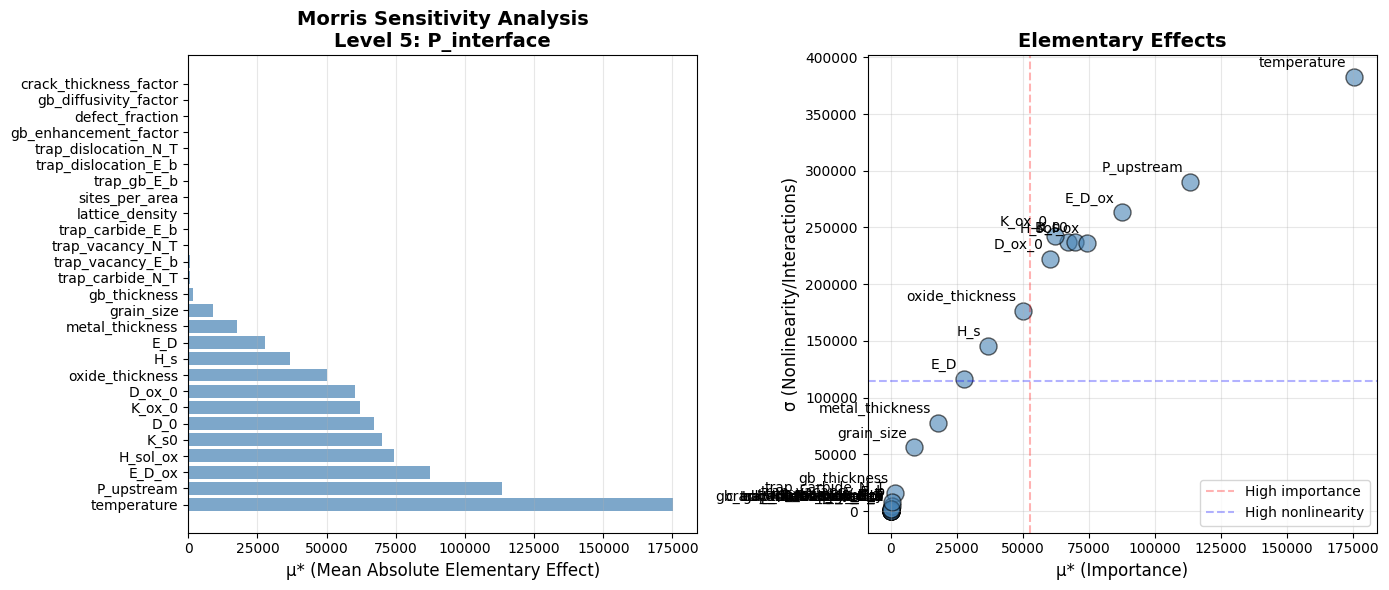


MORRIS SENSITIVITY RESULTS - Level 5: P_interface
             Parameter           μ*            σ      μ*_conf
           temperature 1.752282e+05 3.826549e+05 3.397591e+04
            P_upstream 1.134928e+05 2.897233e+05 2.652416e+04
                E_D_ox 8.753284e+04 2.632172e+05 2.163308e+04
              H_sol_ox 7.421606e+04 2.360965e+05 2.370139e+04
                  K_s0 6.993331e+04 2.374634e+05 2.293086e+04
                   D_0 6.719943e+04 2.373248e+05 2.204528e+04
                K_ox_0 6.217256e+04 2.428144e+05 2.012292e+04
                D_ox_0 6.043728e+04 2.222538e+05 2.083342e+04
       oxide_thickness 5.007545e+04 1.766397e+05 1.451147e+04
                   H_s 3.690177e+04 1.454767e+05 1.347393e+04
                   E_D 2.763980e+04 1.160239e+05 1.109280e+04
       metal_thickness 1.778247e+04 7.731678e+04 7.132393e+03
            grain_size 8.879905e+03 5.603797e+04 5.066638e+03
          gb_thickness 1.669151e+03 1.551480e+04 1.279730e+03
      trap_carbide_

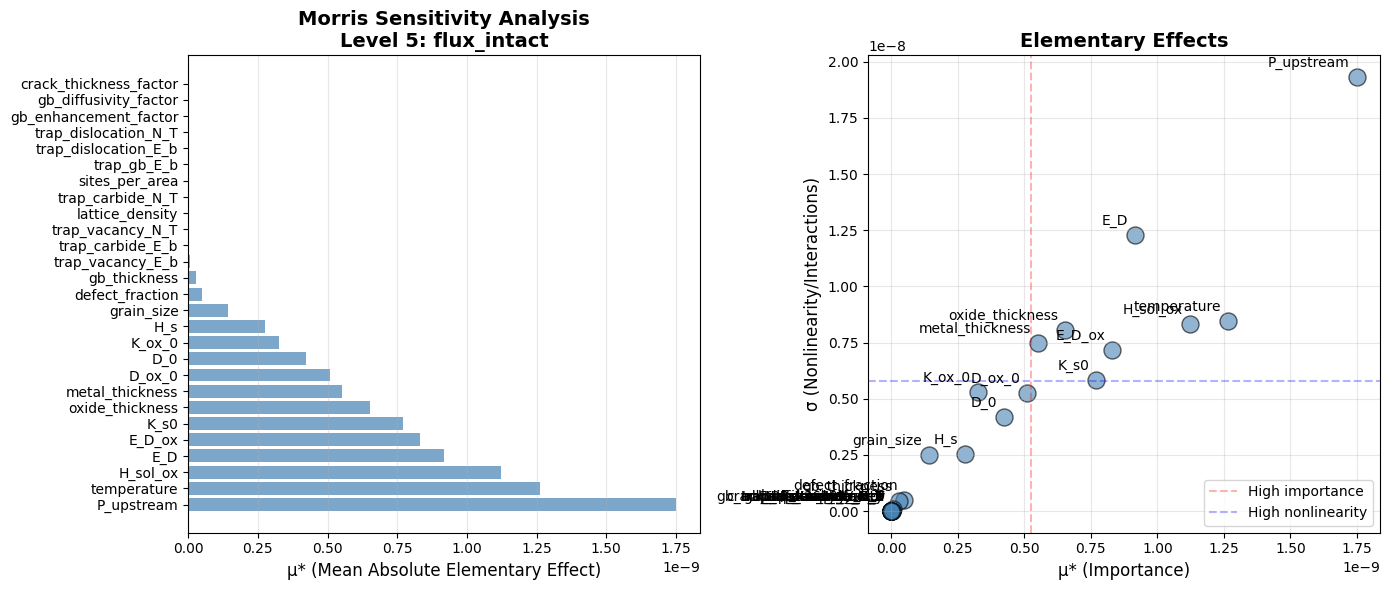


MORRIS SENSITIVITY RESULTS - Level 5: flux_intact
             Parameter           μ*            σ      μ*_conf
            P_upstream 1.749676e-09 1.932113e-08 1.694892e-09
           temperature 1.264117e-09 8.442706e-09 7.226669e-10
              H_sol_ox 1.122131e-09 8.341076e-09 7.815695e-10
                   E_D 9.163061e-10 1.227572e-08 1.162543e-09
                E_D_ox 8.310745e-10 7.174493e-09 6.345401e-10
                  K_s0 7.708454e-10 5.827534e-09 5.324259e-10
       oxide_thickness 6.534260e-10 8.077439e-09 6.657264e-10
       metal_thickness 5.512740e-10 7.469808e-09 6.273241e-10
                D_ox_0 5.102172e-10 5.240862e-09 4.506315e-10
                   D_0 4.228626e-10 4.185755e-09 4.011008e-10
                K_ox_0 3.248274e-10 5.302491e-09 4.247680e-10
                   H_s 2.761346e-10 2.533969e-09 2.390618e-10
            grain_size 1.429301e-10 2.480460e-09 2.270003e-10
       defect_fraction 4.906551e-11 4.920819e-10 4.664869e-11
          gb_thickn

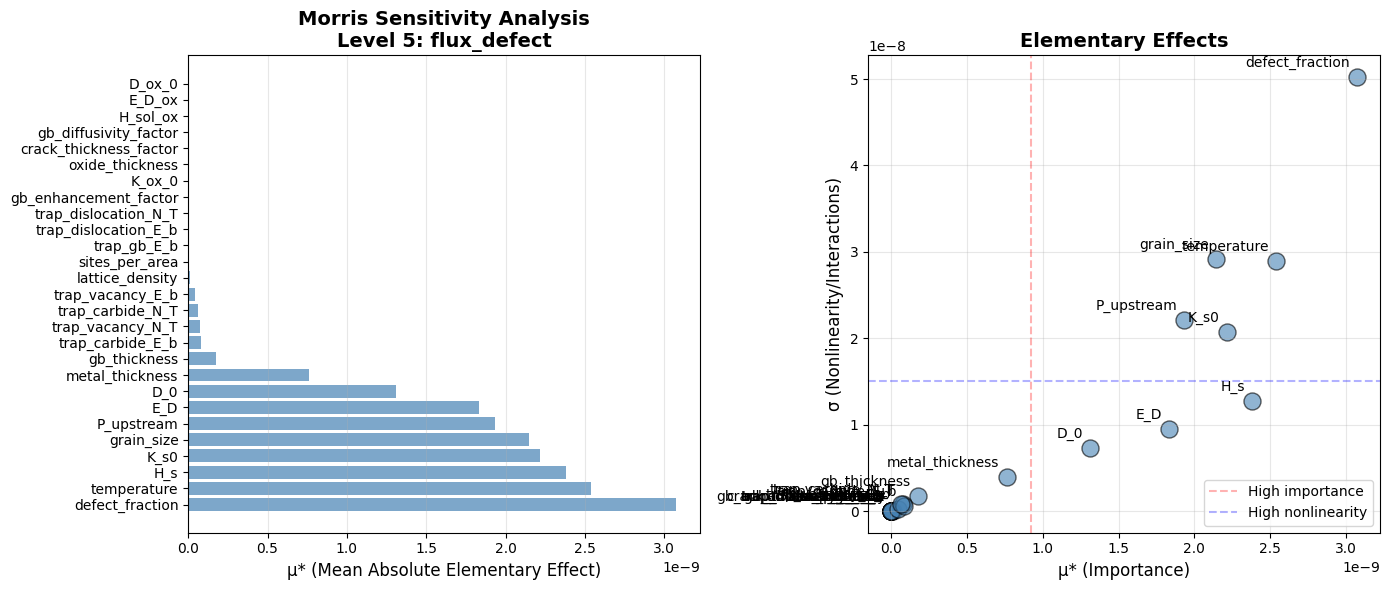


MORRIS SENSITIVITY RESULTS - Level 5: flux_defect
             Parameter           μ*            σ      μ*_conf
       defect_fraction 3.072409e-09 5.022853e-08 3.956165e-09
           temperature 2.541355e-09 2.889256e-08 2.423631e-09
                   H_s 2.383485e-09 1.275820e-08 1.031872e-09
                  K_s0 2.214367e-09 2.075451e-08 1.639423e-09
            grain_size 2.145619e-09 2.917660e-08 2.669123e-09
            P_upstream 1.932048e-09 2.210284e-08 1.785053e-09
                   E_D 1.832533e-09 9.462322e-09 8.534673e-10
                   D_0 1.310909e-09 7.270743e-09 6.783848e-10
       metal_thickness 7.604287e-10 3.889966e-09 3.205585e-10
          gb_thickness 1.726304e-10 1.735064e-09 1.568572e-10
      trap_carbide_E_b 8.080828e-11 6.278885e-10 4.343186e-11
      trap_vacancy_N_T 7.675388e-11 7.874225e-10 7.599594e-11
      trap_carbide_N_T 6.103077e-11 7.858511e-10 6.011934e-11
      trap_vacancy_E_b 4.328498e-11 2.569569e-10 2.288540e-11
       lattice_dens

In [18]:
# =============================================================================
# PLOT MORRIS RESULTS FOR ALL OUTPUTS
# =============================================================================

for output_metric in VALID_OUTPUT_METRICS_L5:
    print(f"\n{'='*70}")
    print(f"OUTPUT: {output_metric}")
    print(f"{'='*70}")
    
    Si = morris_results[output_metric]['Si']
    problem = morris_results[output_metric]['problem']
    
    plot_morris_results(Si, problem, f'Level 5: {output_metric}')

In [19]:
# =============================================================================
# PARAMETER IMPORTANCE RANKING ACROSS ALL 8 OUTPUTS
# =============================================================================
import pandas as pd

param_names = morris_results['flux']['problem']['names']

# Build DataFrame with μ* for each output
df_all = pd.DataFrame({'Parameter': param_names})

for output_metric in VALID_OUTPUT_METRICS_L5:
    df_all[f'μ*_{output_metric}'] = morris_results[output_metric]['Si']['mu_star']

# Normalize each column
for output_metric in VALID_OUTPUT_METRICS_L5:
    col = f'μ*_{output_metric}'
    max_val = df_all[col].max()
    if max_val > 0:
        df_all[f'{col}_norm'] = df_all[col] / max_val
    else:
        df_all[f'{col}_norm'] = 0

# Average normalized importance across all outputs
norm_cols = [f'μ*_{m}_norm' for m in VALID_OUTPUT_METRICS_L5]
df_all['Avg_Importance'] = df_all[norm_cols].mean(axis=1)
df_all = df_all.sort_values('Avg_Importance', ascending=False)

# Display summary
print("="*100)
print("PARAMETER IMPORTANCE RANKING (Morris μ* - All 8 Outputs)")
print("="*100)
display_cols = ['Parameter'] + [f'μ*_{m}' for m in VALID_OUTPUT_METRICS_L5] + ['Avg_Importance']
print(df_all[display_cols].to_string(index=False))
print("="*100)

# Top 10 for Sobol
top_10 = df_all.head(10)['Parameter'].tolist()
print(f"\n→ Top 10 parameters for focused Sobol analysis:")
for i, p in enumerate(top_10, 1):
    importance = df_all[df_all['Parameter'] == p]['Avg_Importance'].values[0]
    print(f"   {i:2d}. {p:<25s} (avg importance: {importance:.3f})")

PARAMETER IMPORTANCE RANKING (Morris μ* - All 8 Outputs)
             Parameter      μ*_flux       μ*_PRF     μ*_D_eff  μ*_D_modification  μ*_permeability  μ*_P_interface  μ*_flux_intact  μ*_flux_defect  Avg_Importance
           temperature 3.477770e-09 2.073212e+03 5.253088e-08       2.411147e+00     1.024223e-13    1.752282e+05    1.264117e-09    2.541355e-09    8.213800e-01
                   E_D 2.748839e-09 2.860097e+02 5.084593e-08       3.287374e-16     9.778384e-14    2.763980e+04    9.163061e-10    1.832533e-09    4.795125e-01
            grain_size 2.288549e-09 8.043017e+01 2.040723e-08       2.932449e+00     6.341149e-14    8.879905e+03    1.429301e-10    2.145619e-09    4.207425e-01
            P_upstream 3.681723e-09 2.064871e+02 0.000000e+00       0.000000e+00     0.000000e+00    1.134928e+05    1.749676e-09    1.932048e-09    4.149626e-01
                  K_s0 2.985212e-09 4.668478e+02 0.000000e+00       0.000000e+00     6.791693e-14    6.993331e+04    7.708454e-10    

### Sensitivity Heatmap

This heatmap shows which parameters affect which outputs:
- **Yellow/Light**: Low sensitivity (parameter has little effect)
- **Red/Dark**: High sensitivity (parameter strongly affects output)

**Interpretation:**
- A **row with all dark cells** = parameter affects everything (universally important)
- A **column with few dark cells** = that output is controlled by only a few parameters
- **Clusters of dark cells** reveal which parameter groups dominate specific outputs

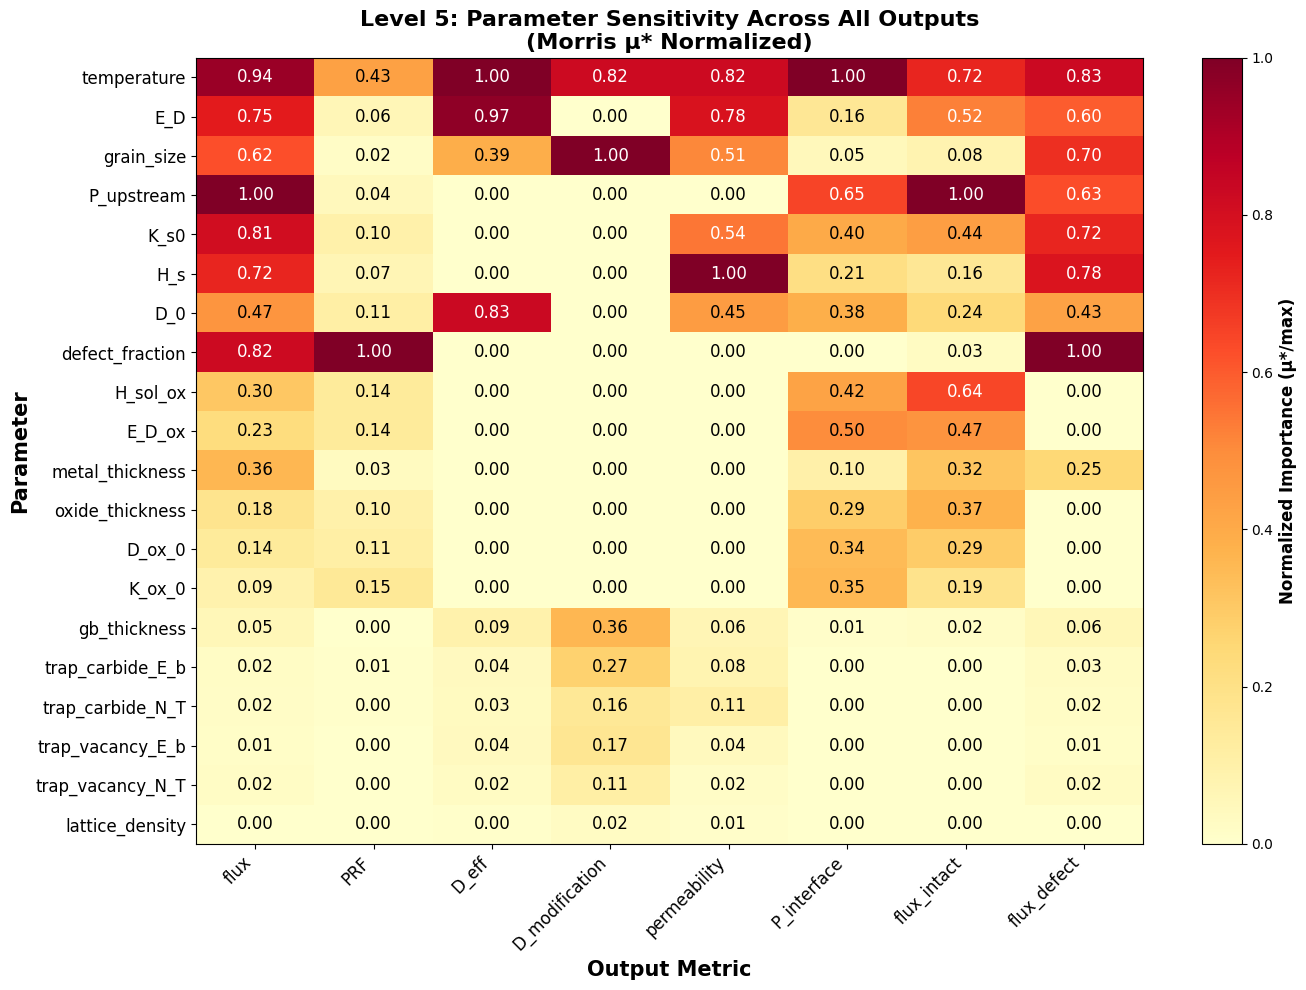

In [20]:
# =============================================================================
# HEATMAP: Parameter Importance Across All Outputs
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Get top 20 parameters for visualization
top_20 = df_all.head(20)

# Extract normalized values for heatmap
heatmap_data = top_20[[f'μ*_{m}_norm' for m in VALID_OUTPUT_METRICS_L5]].values
param_labels = top_20['Parameter'].tolist()
output_labels = VALID_OUTPUT_METRICS_L5

fig, ax = plt.subplots(figsize=(14, 10))

im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')

# Labels
ax.set_xticks(np.arange(len(output_labels)))
ax.set_yticks(np.arange(len(param_labels)))
ax.set_xticklabels(output_labels, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(param_labels, fontsize=12)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Importance (μ*/max)', fontsize=12, fontweight='bold')

# Annotate cells with values
for i in range(len(param_labels)):
    for j in range(len(output_labels)):
        val = heatmap_data[i, j]
        color = 'white' if val > 0.5 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=12)

ax.set_title('Level 5: Parameter Sensitivity Across All Outputs\n(Morris μ* Normalized)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Output Metric', fontsize=15, fontweight='bold')
ax.set_ylabel('Parameter', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Sobol Analysis


Top 10 parameters for focused Sobol analysis:

    1. temperature               (avg importance: 0.780)
    2. E_D                       (avg importance: 0.540)
    3. H_s                       (avg importance: 0.511)
    4. D_0                       (avg importance: 0.412)
    5. K_s0                      (avg importance: 0.319)
    6. E_D_ox                    (avg importance: 0.253)
    7. P_upstream                (avg importance: 0.253)
    8. defect_fraction           (avg importance: 0.245)
    9. H_sol_ox                  (avg importance: 0.235)
   10. grain_size                (avg importance: 0.197)

In [21]:
# # =============================================================================
# # CREATE FOCUSED RANGES FOR SOBOL (Top 10 from Morris)
# # =============================================================================

# # Top 10 parameters already extracted from Morris ranking
# top_10_params = df_all.head(10)['Parameter'].tolist()

# # Extract their ranges from SUGGESTED_RANGES_LEVEL5
# SOBOL_FOCUSED_RANGES = {param: SUGGESTED_RANGES_LEVEL5[param] for param in top_10_params}

# print("="*70)
# print("FOCUSED PARAMETER RANGES FOR SOBOL ANALYSIS")
# print("="*70)
# for i, (param, bounds) in enumerate(SOBOL_FOCUSED_RANGES.items(), 1):
#     importance = df_all[df_all['Parameter'] == param]['Avg_Importance'].values[0]
#     print(f"  {i:2d}. {param:<25s}: [{bounds[0]:.2e}, {bounds[1]:.2e}]  (μ*={importance:.3f})")
# print("="*70)
# print(f"\nReduced from {len(SUGGESTED_RANGES_LEVEL5)} → {len(SOBOL_FOCUSED_RANGES)} parameters")

In [22]:
# =============================================================================
# CREATE FOCUSED RANGES FOR SOBOL (Top 10 from Morris Heatmap)
# =============================================================================

# top_10 already exists from the ranking cell above
SOBOL_FOCUSED_RANGES = {param: SUGGESTED_RANGES_LEVEL5[param] for param in top_10}

print("="*70)
print("FOCUSED PARAMETER RANGES FOR SOBOL (Top 10 from Heatmap)")
print("="*70)
for i, (param, bounds) in enumerate(SOBOL_FOCUSED_RANGES.items(), 1):
    importance = df_all[df_all['Parameter'] == param]['Avg_Importance'].values[0]
    print(f"  {i:2d}. {param:<25s}: [{bounds[0]:.2e}, {bounds[1]:.2e}]  (μ*={importance:.3f})")
print("="*70)

FOCUSED PARAMETER RANGES FOR SOBOL (Top 10 from Heatmap)
   1. temperature              : [5.73e+02, 1.27e+03]  (μ*=0.821)
   2. E_D                      : [4.00e+04, 7.00e+04]  (μ*=0.480)
   3. grain_size               : [1.00e-07, 1.00e-04]  (μ*=0.421)
   4. P_upstream               : [1.00e+03, 1.00e+06]  (μ*=0.415)
   5. K_s0                     : [1.00e-10, 1.00e-07]  (μ*=0.377)
   6. H_s                      : [-4.00e+04, 0.00e+00]  (μ*=0.366)
   7. D_0                      : [1.00e-08, 1.00e-05]  (μ*=0.364)
   8. defect_fraction          : [1.00e-04, 1.00e-01]  (μ*=0.356)
   9. H_sol_ox                 : [1.50e+05, 2.20e+05]  (μ*=0.188)
  10. E_D_ox                   : [1.20e+05, 2.00e+05]  (μ*=0.167)


In [23]:
# =============================================================================
# SOBOL ANALYSIS: TOP 10 PARAMETERS (from Morris screening)
# =============================================================================
# Set random seeds for reproducibility


sobol_results = {}

for output_metric in VALID_OUTPUT_METRICS_L5:
    print(f"\n{'#'*70}")
    print(f"# Running Sobol for: {output_metric}")
    print(f"{'#'*70}")
    
    Si, problem, Y = sobol_sensitivity_level5(
        SOBOL_FOCUSED_RANGES,  # Use focused ranges from Morris top 10
        N_samples=1024,              # Samples (total = N × (2D + 2) = 22,528)
        output_metric=output_metric
        
        
    )
  
    sobol_results[output_metric] = {
        'Si': Si,
        'problem': problem,
        'Y': Y
    }

print("\n" + "="*70)
print("✓ Sobol analysis complete for all output metrics!")
print("="*70)


######################################################################
# Running Sobol for: flux
######################################################################

SOBOL SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 22528 Sobol samples (N_base=1024, 10 params)
Parameters: temperature, E_D, grain_size, P_upstream, K_s0, H_s, D_0, defect_fraction, H_sol_ox, E_D_ox
Output metric: flux
Second-order interactions: Yes
⏳ This may take a while...



/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:613: UserWarning: Temperature 574.0 K is far outside data range [873.1, 1273.2] K. Clamping to nearest data limit for interpolation.
  warnings.warn(
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1951: UserWarning: GB traps already in trap_list, not adding automatically
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/a

  Completed 2252/22528 samples (10%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.13×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.13×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.27×) and trapping (0.98×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:613: UserWarning: Temperature 582.2 K is far outside data range [873.1, 1273.2] K. Clamping to 

  Completed 4504/22528 samples (20%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:613: UserWarning: Temperature 609.6 K is far outside data range [873.1, 1273.2] K. Clamping to nearest data limit for interpolation.
  warnings.warn(
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:613: UserWarning: Temperature 631.4 K is far outside data range [873.1, 1273.2] K. Clamping to nearest data limit for interpolation.
  warnings.warn(
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.10×) and trapping (0.97×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.05×) and trapping (0.97×) nearly cancel. Small parameter changes could signi

  Completed 6756/22528 samples (30%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 851.6 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 690.2 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 764.1 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:613: UserWarning: Tempe

  Completed 9008/22528 samples (40%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.23×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.25×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.13×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.07×) and trapping (0.96×) nearly cancel. Small parameter c

  Completed 11260/22528 samples (50%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 749.7 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 857.7 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 837.2 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Tempe

  Completed 13512/22528 samples (60%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 786.6 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 820.8 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 699.1 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:613: UserWarning: Tempe

  Completed 15764/22528 samples (70%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 829.0 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 745.6 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:613: UserWarning: Temperature 658.1 K is far outside data range [873.1, 1273.2] K. Clamping to nearest data limit for interpolation.
  warnings.warn(
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 833.1 K is outside data ra

  Completed 18016/22528 samples (80%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.25×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.18×) and trapping (0.98×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.22×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.14×) and trapping (0.98×) nearly cancel. Small parameter c

  Completed 20268/22528 samples (90%)


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.06×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 22520/22528 samples (100%)
  Completed 22528/22528 samples (100%)

✓ Sobol analysis complete
  Output range: [3.33e-17, 3.78e-08]
  Output span: 1134257473.3× variation

  Parameter                       S1       ST    ST-S1
  ------------------------- -------- -------- --------
  E_D                         -0.010    0.478    0.489
  H_s                          0.101    0.390    0.289
  defect_fraction             -0.023    0.221    0.244
  K_s0                         0.021    0.196    0.176
  D_0                          0.012    0.177    0.165
  P_upstream                   0.016    0.063    0.048
  temperature                  0.005    0.062    0.057
  grain_size                  -0.003    0.004    0.007
  E_D_ox                      -0.000    0.000    0.000
  H_sol_ox                    -0.000    0.000    0.000

  Sum(S1) = 0.119 (should be ~1 if additive)
  Sum(ST) = 1.593 (>1 indicates interactions)

  Top parameter interactions (S2 > 0.01):
    temperature × E_D: 


OUTPUT: flux


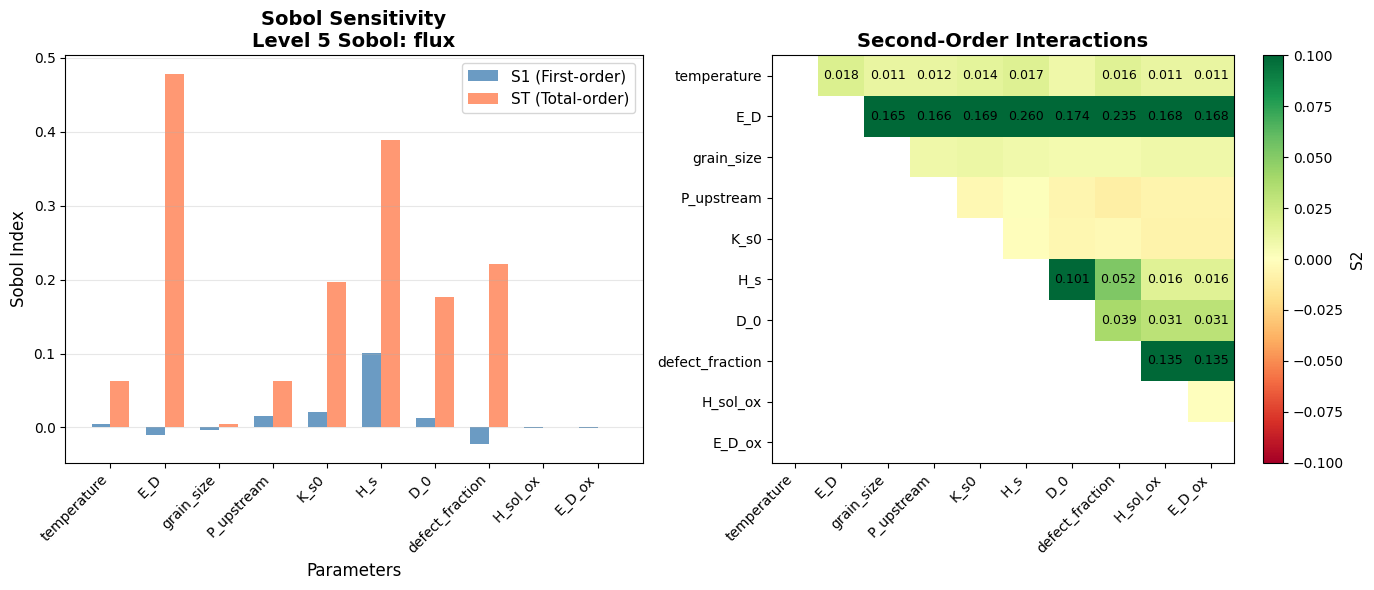


SOBOL SENSITIVITY RESULTS - Level 5 Sobol: flux
      Parameter        S1  S1_conf           ST      ST_conf  Interactions
    temperature  0.004938 0.009781 6.243101e-02 4.115154e-02      0.057493
            E_D -0.010225 0.073285 4.784827e-01 3.122837e-01      0.488708
     grain_size -0.002953 0.003690 4.292979e-03 7.155888e-03      0.007246
     P_upstream  0.015648 0.020772 6.315438e-02 4.133930e-02      0.047507
           K_s0  0.020824 0.020695 1.964642e-01 1.018869e-01      0.175640
            H_s  0.101059 0.088418 3.895606e-01 2.001926e-01      0.288501
            D_0  0.012472 0.017030 1.771948e-01 9.242327e-02      0.164723
defect_fraction -0.022693 0.076979 2.210979e-01 9.803939e-02      0.243791
       H_sol_ox -0.000077 0.000172 7.676869e-07 5.370290e-07      0.000077
         E_D_ox -0.000102 0.000203 7.178338e-06 1.037705e-05      0.000109

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure

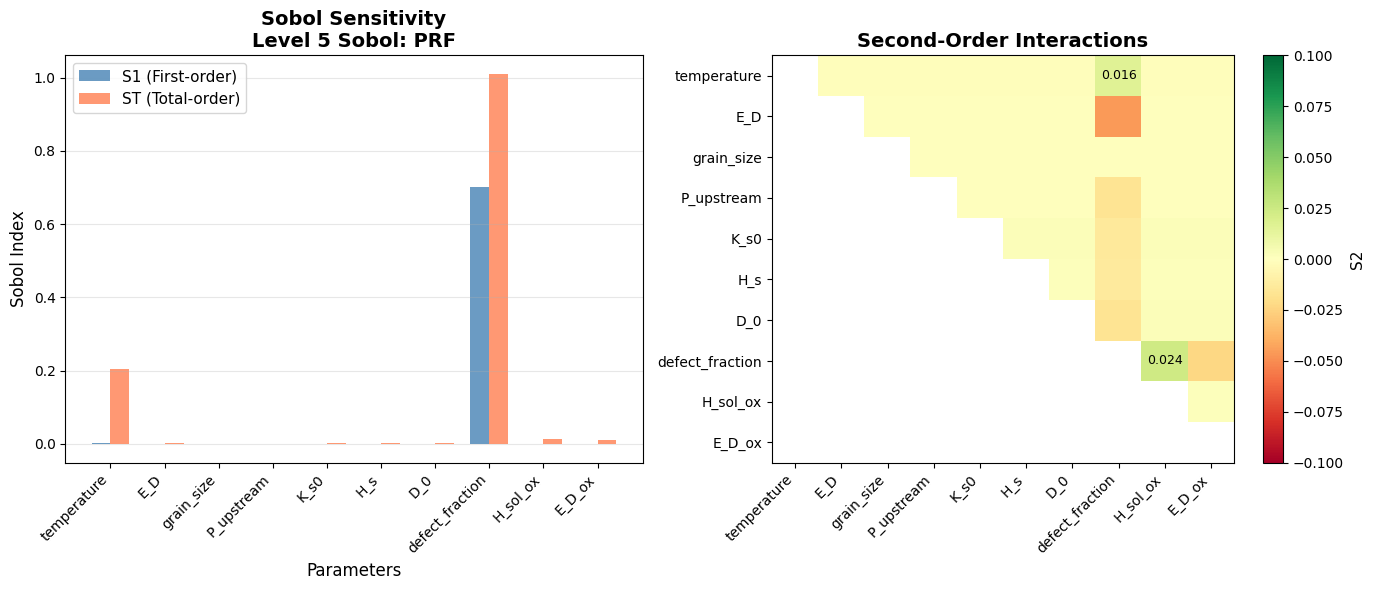


SOBOL SENSITIVITY RESULTS - Level 5 Sobol: PRF
      Parameter        S1  S1_conf           ST      ST_conf  Interactions
    temperature  0.002772 0.007303 2.052997e-01 2.459523e-01      0.202528
            E_D  0.000466 0.000709 2.398413e-03 4.672607e-03      0.001933
     grain_size -0.000002 0.000004 2.253084e-08 6.094851e-08      0.000002
     P_upstream -0.000051 0.000379 4.643269e-04 7.912734e-04      0.000515
           K_s0 -0.000497 0.001309 1.962920e-03 5.171898e-03      0.002460
            H_s -0.000335 0.000980 1.279184e-03 3.494515e-03      0.001614
            D_0 -0.000469 0.001171 1.990844e-03 3.752678e-03      0.002460
defect_fraction  0.700649 0.638387 1.010483e+00 1.942141e-02      0.309834
       H_sol_ox -0.001291 0.003417 1.400823e-02 3.990287e-02      0.015299
         E_D_ox  0.000030 0.002152 1.095827e-02 2.020930e-02      0.010928

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure 

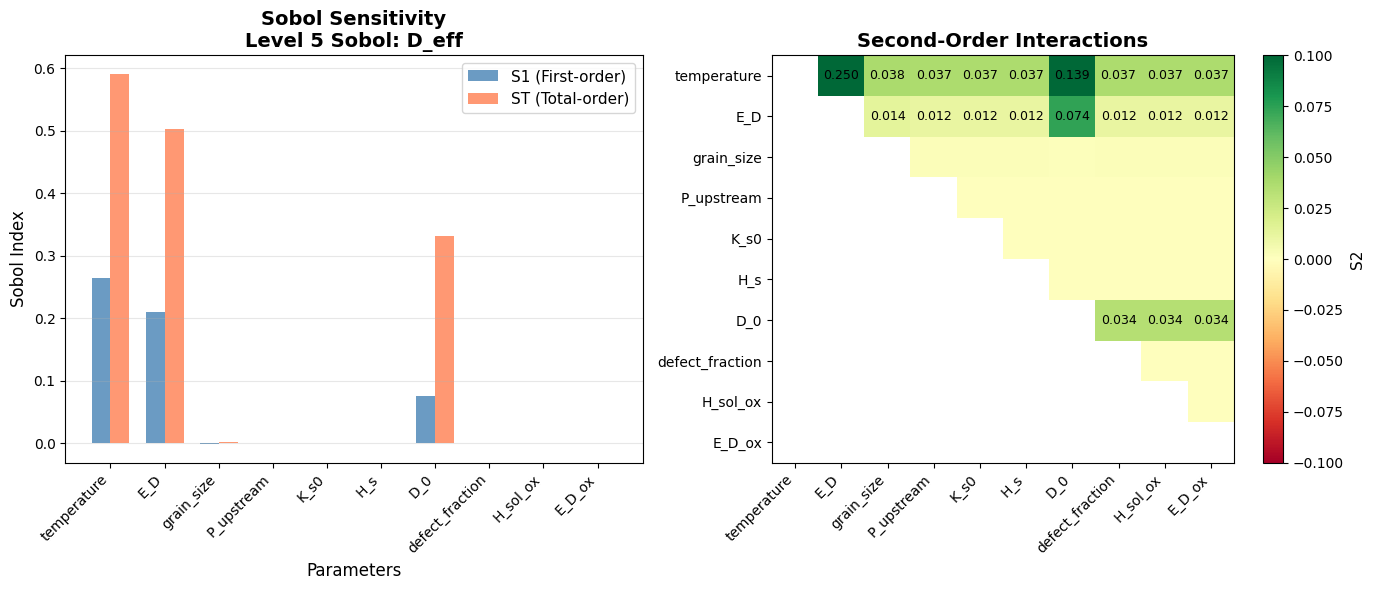


SOBOL SENSITIVITY RESULTS - Level 5 Sobol: D_eff
      Parameter        S1  S1_conf       ST  ST_conf  Interactions
    temperature  0.265195 0.086378 0.591387 0.120327      0.326192
            E_D  0.210540 0.076730 0.503336 0.117186      0.292796
     grain_size -0.001274 0.002236 0.002706 0.002799      0.003980
     P_upstream  0.000000 0.000000 0.000000 0.000000      0.000000
           K_s0  0.000000 0.000000 0.000000 0.000000      0.000000
            H_s  0.000000 0.000000 0.000000 0.000000      0.000000
            D_0  0.075557 0.035660 0.332053 0.099628      0.256496
defect_fraction  0.000000 0.000000 0.000000 0.000000      0.000000
       H_sol_ox  0.000000 0.000000 0.000000 0.000000      0.000000
         E_D_ox  0.000000 0.000000 0.000000 0.000000      0.000000

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure interaction effects

Top 3 Most Influential Parameters:
  temperature: ST = 0.591 (S1 

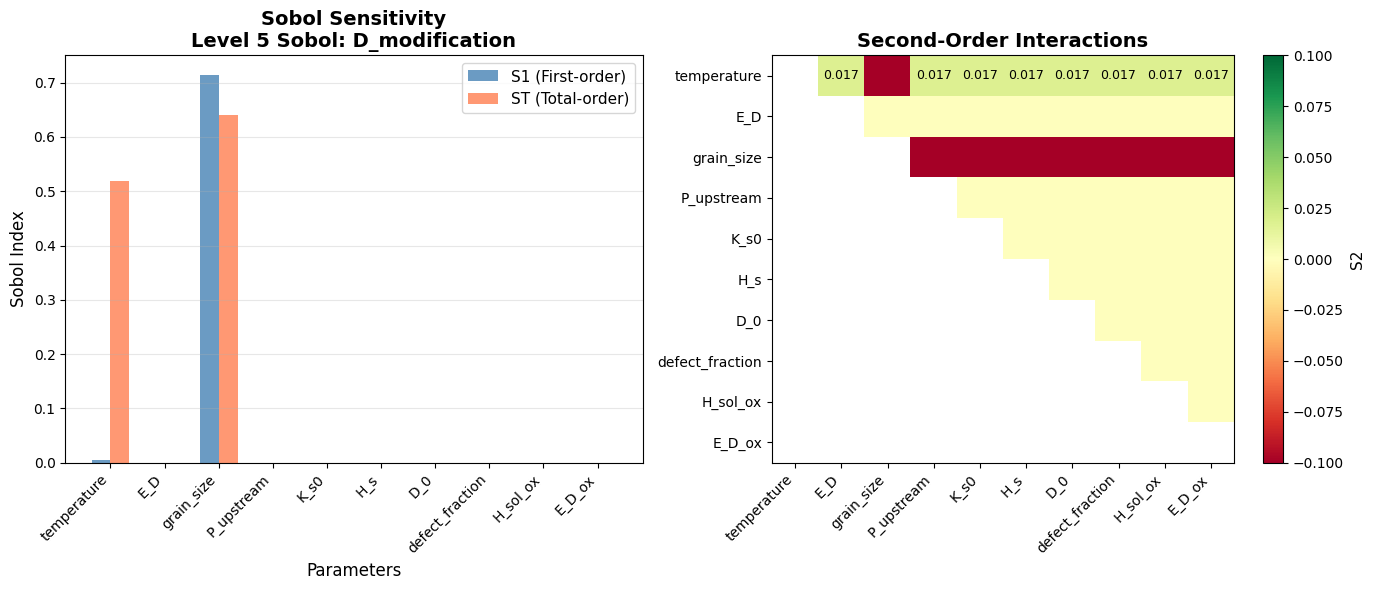


SOBOL SENSITIVITY RESULTS - Level 5 Sobol: D_modification
      Parameter            S1      S1_conf           ST      ST_conf  Interactions
    temperature  4.756672e-03 1.684348e-02 5.190396e-01 1.915103e+00  5.142829e-01
            E_D -1.960112e-17 6.351961e-17 8.649678e-31 2.070130e-30  1.960112e-17
     grain_size  7.146679e-01 3.821071e-01 6.404639e-01 5.491952e-01 -7.420403e-02
     P_upstream  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00  0.000000e+00
           K_s0  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00  0.000000e+00
            H_s  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00  0.000000e+00
            D_0  1.068975e-18 5.083682e-17 8.290250e-31 1.919176e-30 -1.068975e-18
defect_fraction  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00  0.000000e+00
       H_sol_ox  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00  0.000000e+00
         E_D_ox  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00  0.000000e+00

Interpretation:
  S1 : Firs

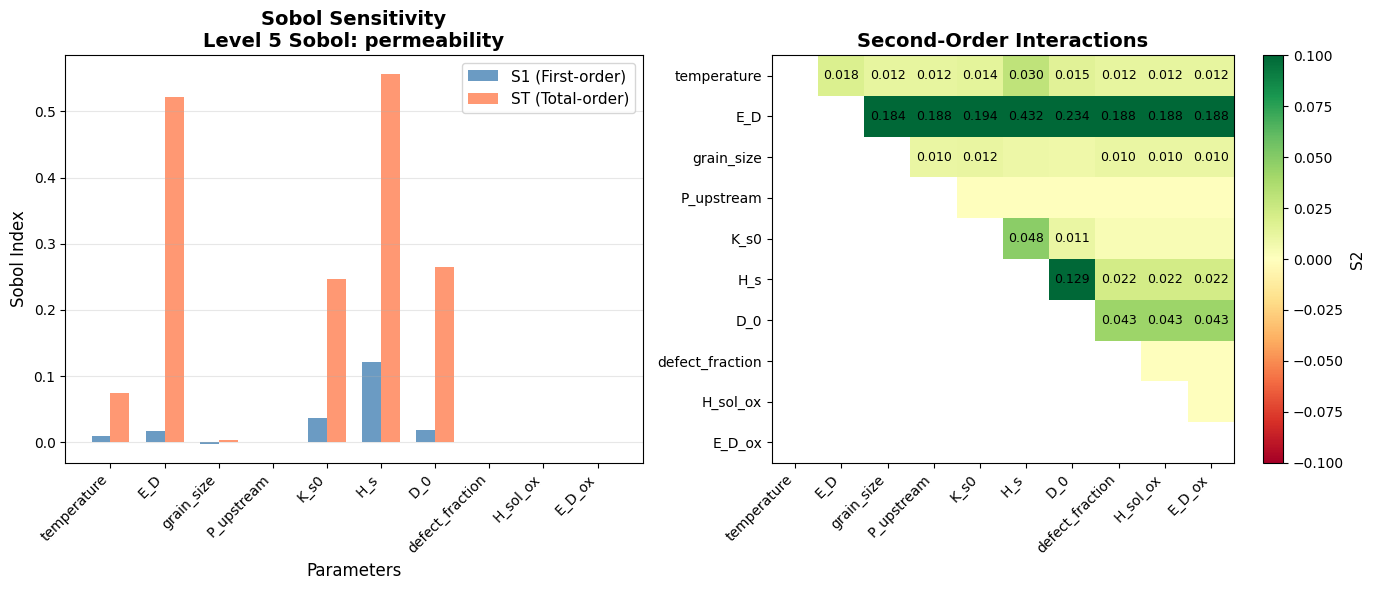


SOBOL SENSITIVITY RESULTS - Level 5 Sobol: permeability
      Parameter        S1  S1_conf       ST  ST_conf  Interactions
    temperature  0.009057 0.010648 0.074245 0.032192      0.065187
            E_D  0.017401 0.071646 0.522471 0.152899      0.505070
     grain_size -0.003106 0.005189 0.002987 0.004702      0.006093
     P_upstream  0.000000 0.000000 0.000000 0.000000      0.000000
           K_s0  0.036435 0.029356 0.245919 0.134582      0.209483
            H_s  0.120570 0.068770 0.556722 0.189970      0.436152
            D_0  0.017985 0.019688 0.264999 0.116001      0.247014
defect_fraction  0.000000 0.000000 0.000000 0.000000      0.000000
       H_sol_ox  0.000000 0.000000 0.000000 0.000000      0.000000
         E_D_ox  0.000000 0.000000 0.000000 0.000000      0.000000

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure interaction effects

Top 3 Most Influential Parameters:
  H_s: ST = 0.557 (S1 =

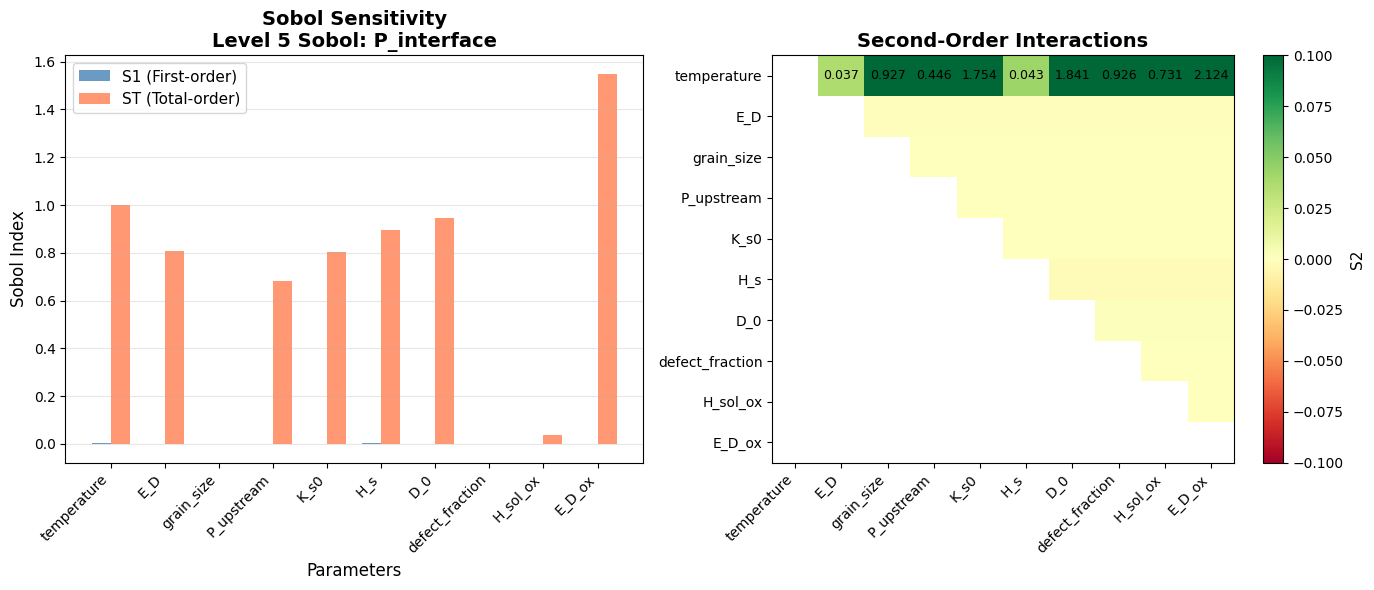


SOBOL SENSITIVITY RESULTS - Level 5 Sobol: P_interface
      Parameter            S1  S1_conf           ST      ST_conf  Interactions
    temperature  1.872514e-03 0.033808 9.988100e-01 1.533305e+00  9.969375e-01
            E_D  1.098912e-03 0.002827 8.084068e-01 6.709219e-01  8.073079e-01
     grain_size -3.735417e-07 0.000007 7.300168e-08 7.302500e-08  4.465434e-07
     P_upstream -3.204156e-04 0.006394 6.821115e-01 2.300612e+00  6.824320e-01
           K_s0 -9.463263e-04 0.069997 8.033031e-01 3.285023e+00  8.042494e-01
            H_s  1.912349e-03 0.003380 8.949511e-01 5.640874e-01  8.930387e-01
            D_0 -9.955451e-04 0.019439 9.468134e-01 6.483417e-01  9.478090e-01
defect_fraction  0.000000e+00 0.000000 0.000000e+00 0.000000e+00  0.000000e+00
       H_sol_ox  2.973211e-04 0.000895 3.742099e-02 3.670440e-02  3.712367e-02
         E_D_ox -1.323542e-03 0.007262 1.549022e+00 9.894356e-01  1.550345e+00

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-

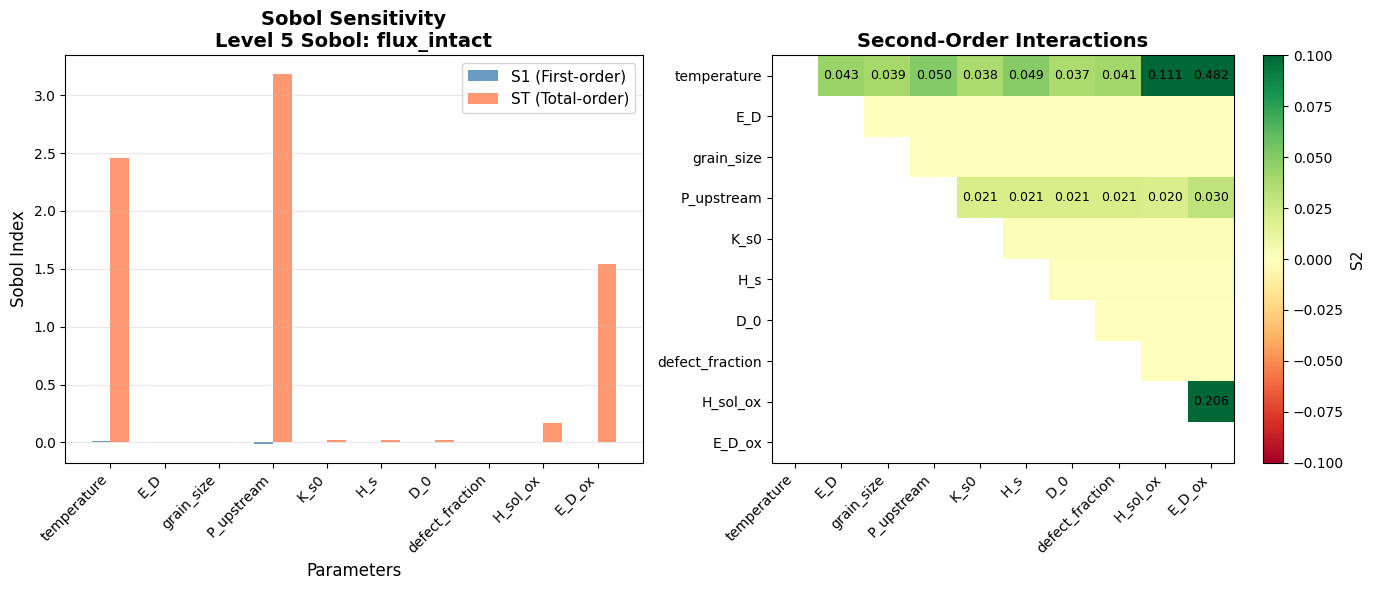


SOBOL SENSITIVITY RESULTS - Level 5 Sobol: flux_intact
      Parameter            S1      S1_conf           ST      ST_conf  Interactions
    temperature  1.502976e-02 2.723827e-02 2.455948e+00 4.343490e+00  2.440918e+00
            E_D  2.737683e-04 1.012544e-03 5.868782e-03 1.559926e-02  5.595013e-03
     grain_size -4.757115e-08 2.287058e-07 3.054558e-10 7.946673e-10  4.787660e-08
     P_upstream -1.616529e-02 2.649218e-02 3.185199e+00 6.291169e+00  3.201364e+00
           K_s0 -6.529846e-04 2.003057e-03 2.128929e-02 5.814678e-02  2.194227e-02
            H_s -9.006091e-04 2.350827e-03 2.264293e-02 6.180248e-02  2.354354e-02
            D_0 -6.443029e-04 1.994901e-03 2.135801e-02 5.821473e-02  2.200232e-02
defect_fraction -2.523646e-06 2.598641e-04 2.734040e-04 3.529775e-04  2.759277e-04
       H_sol_ox  3.729730e-03 8.543116e-03 1.647541e-01 2.406694e-01  1.610244e-01
         E_D_ox  2.515538e-03 2.057139e-02 1.540551e+00 3.305370e+00  1.538036e+00

Interpretation:
  S1 : First-o

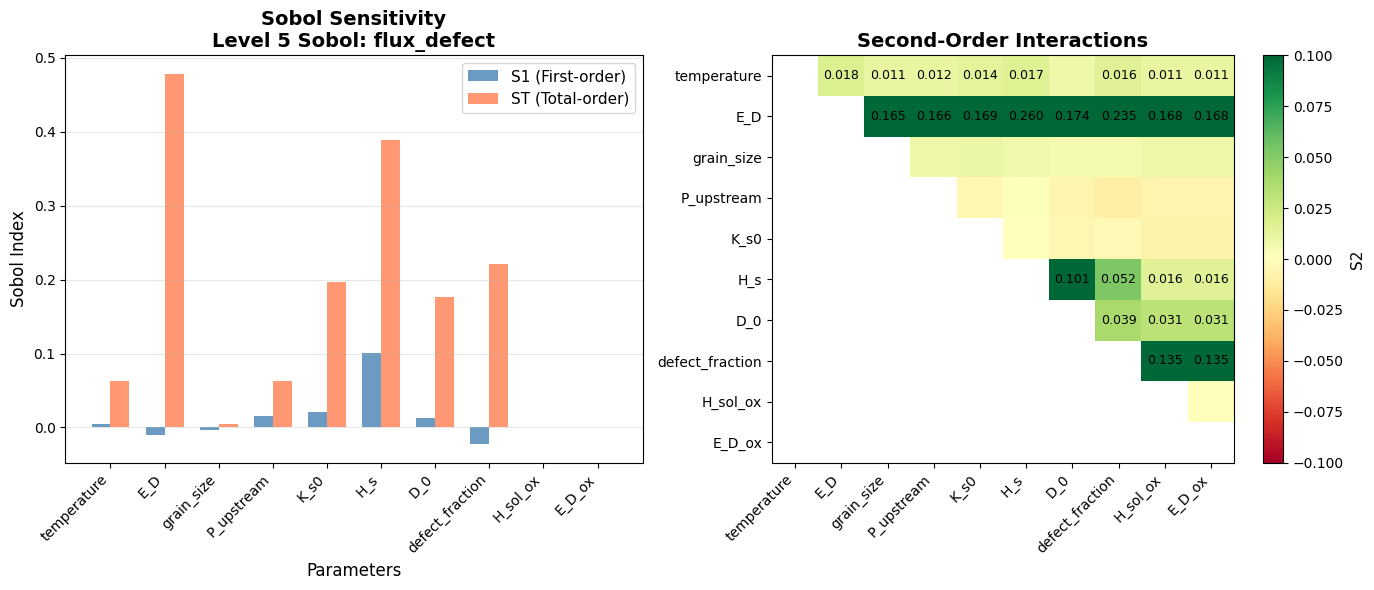


SOBOL SENSITIVITY RESULTS - Level 5 Sobol: flux_defect
      Parameter        S1  S1_conf       ST  ST_conf  Interactions
    temperature  0.004880 0.009779 0.062283 0.041101      0.057403
            E_D -0.010179 0.073313 0.478525 0.312333      0.488703
     grain_size -0.002954 0.003692 0.004293 0.007157      0.007247
     P_upstream  0.015720 0.020761 0.062988 0.041260      0.047268
           K_s0  0.020850 0.020704 0.196481 0.101904      0.175631
            H_s  0.101117 0.088435 0.389594 0.200229      0.288477
            D_0  0.012503 0.017041 0.177210 0.092440      0.164707
defect_fraction -0.022682 0.076998 0.221120 0.098058      0.243802
       H_sol_ox  0.000000 0.000000 0.000000 0.000000      0.000000
         E_D_ox  0.000000 0.000000 0.000000 0.000000      0.000000

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure interaction effects

Top 3 Most Influential Parameters:
  E_D: ST = 0.479 (S1 = 

In [24]:
# =============================================================================
# PLOT SOBOL RESULTS FOR ALL OUTPUTS
# =============================================================================

for output_metric in VALID_OUTPUT_METRICS_L5:
    print(f"\n{'='*70}")
    print(f"OUTPUT: {output_metric}")
    print(f"{'='*70}")
    
    Si = sobol_results[output_metric]['Si']
    problem = sobol_results[output_metric]['problem']
    
    plot_sobol_results(Si, problem, f'Level 5 Sobol: {output_metric}')